Loading data
Starting grid search
Running with original complexity: k_folds=5, epochs=5
Total combinations to evaluate: 162

=== Evaluating combination 1/162 ===
Parameters: {'dropout': 0.3, 'momentum': 0.8, 'batch_size': 32, 'weight_decay': 0.0, 'lr_scheduler': 'noam'}
Training fold 1/5...


/glade/derecho/scratch/yifanl/tmp/ipykernel_93716/1102578741.py:74: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/glade/derecho/scratch/yifanl/tmp/ipykernel_93716/1102578741.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/glade/derecho/scratch/yifanl/tmp/ipykernel_93716/1102578741.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Fold 1 completed in 0.38 minutes
Training fold 2/5...
Fold 2 completed in 0.35 minutes
Training fold 3/5...
Fold 3 completed in 0.37 minutes
Training fold 4/5...
Fold 4 completed in 0.34 minutes
Training fold 5/5...
Fold 5 completed in 0.36 minutes
Combination 1/162 completed in 1.81 minutes
Avg Training Accuracy: 81.28%, Avg Validation Accuracy: 83.43%
Elapsed time: 0.03 hours, Estimated remaining: 4.86 hours
Estimated completion at: 2025-04-23 14:51:31
New best parameters found: {'dropout': 0.3, 'momentum': 0.8, 'batch_size': 32, 'weight_decay': 0.0, 'lr_scheduler': 'noam'} with validation accuracy: 83.43%

=== Evaluating combination 2/162 ===
Parameters: {'dropout': 0.3, 'momentum': 0.8, 'batch_size': 32, 'weight_decay': 0.0, 'lr_scheduler': 'cosine'}
Training fold 1/5...
Fold 1 completed in 0.36 minutes
Training fold 2/5...
Fold 2 completed in 0.36 minutes
Training fold 3/5...
Fold 3 completed in 0.37 minutes
Training fold 4/5...
Fold 4 completed in 0.37 minutes
Training fold 5/5..

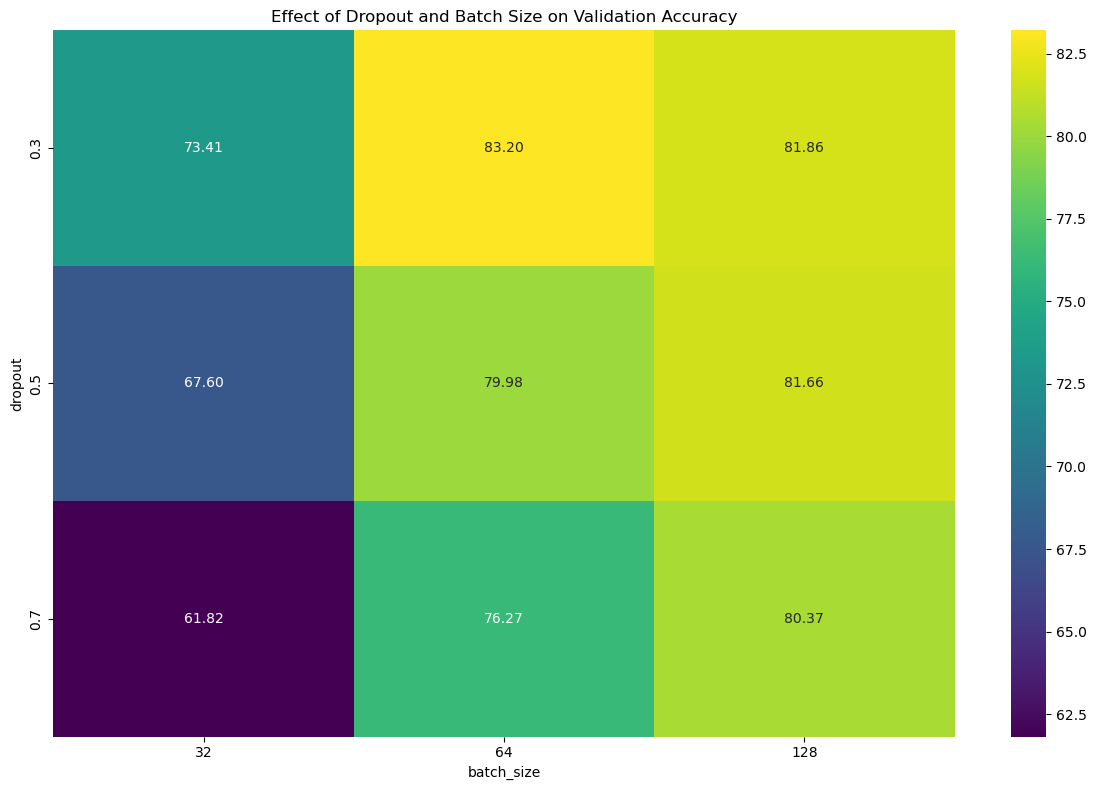

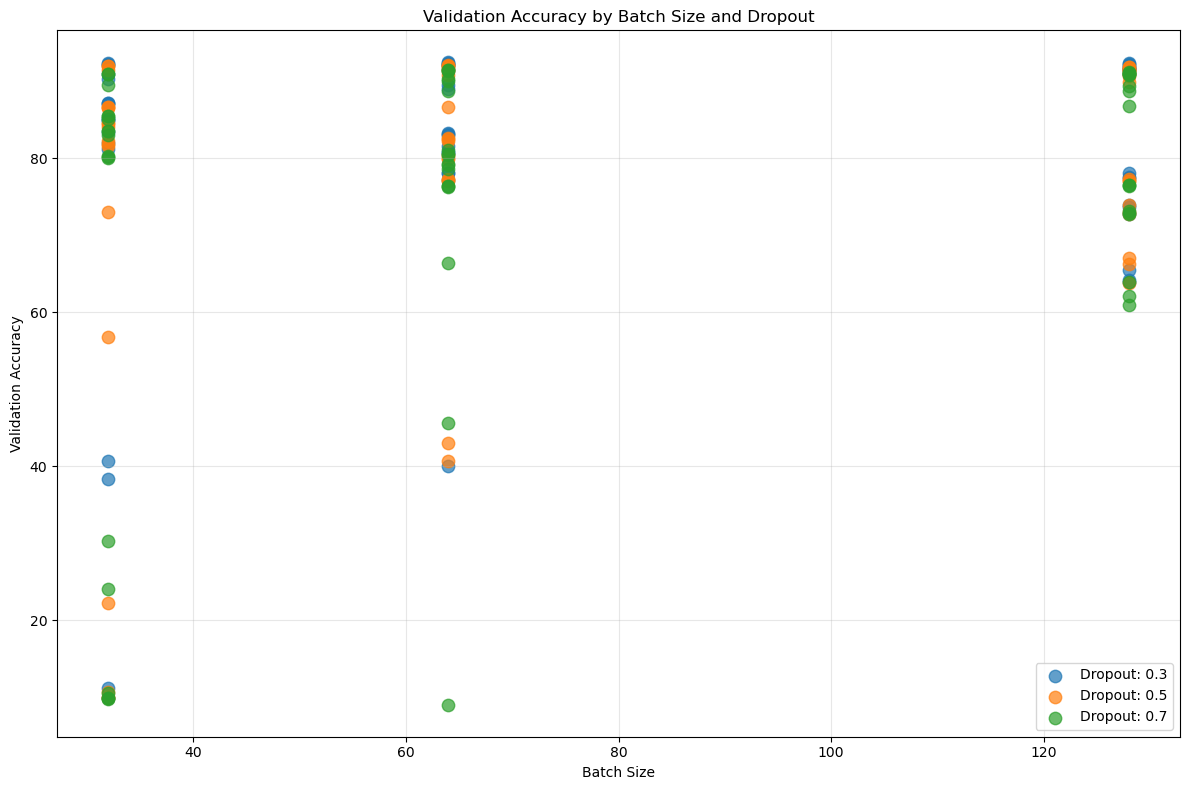

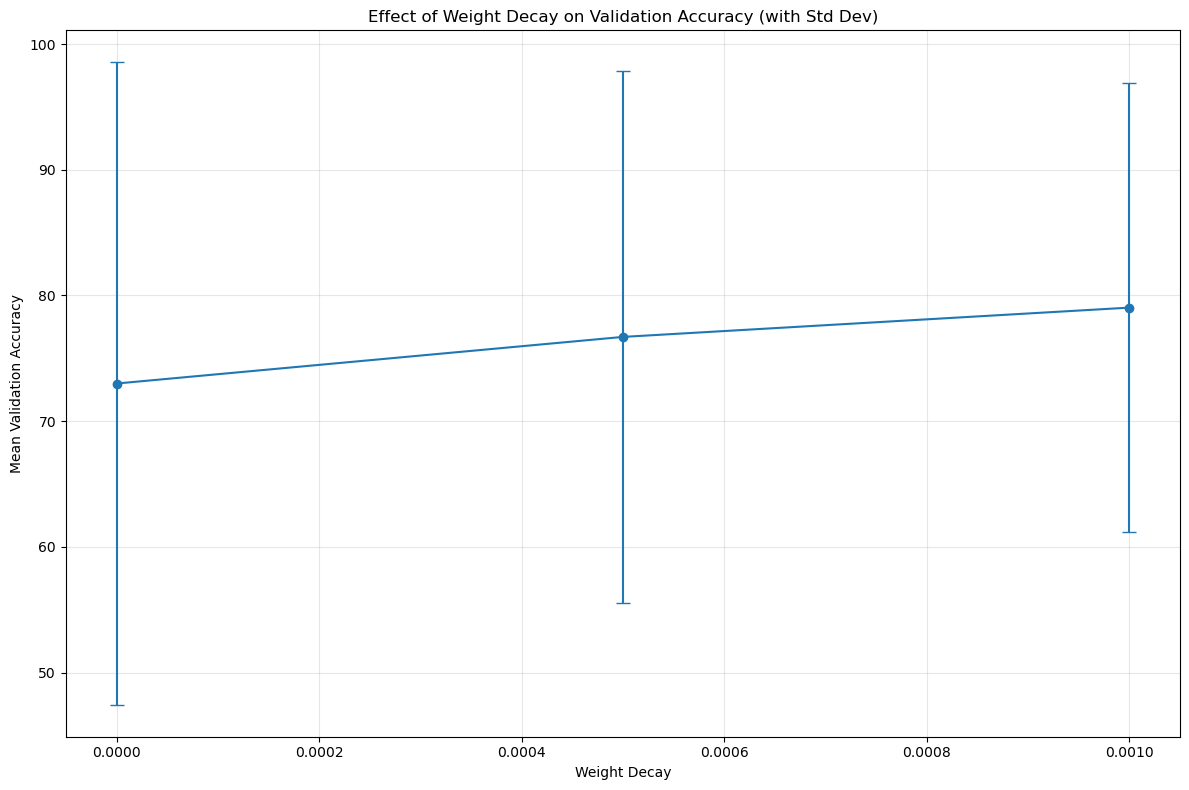

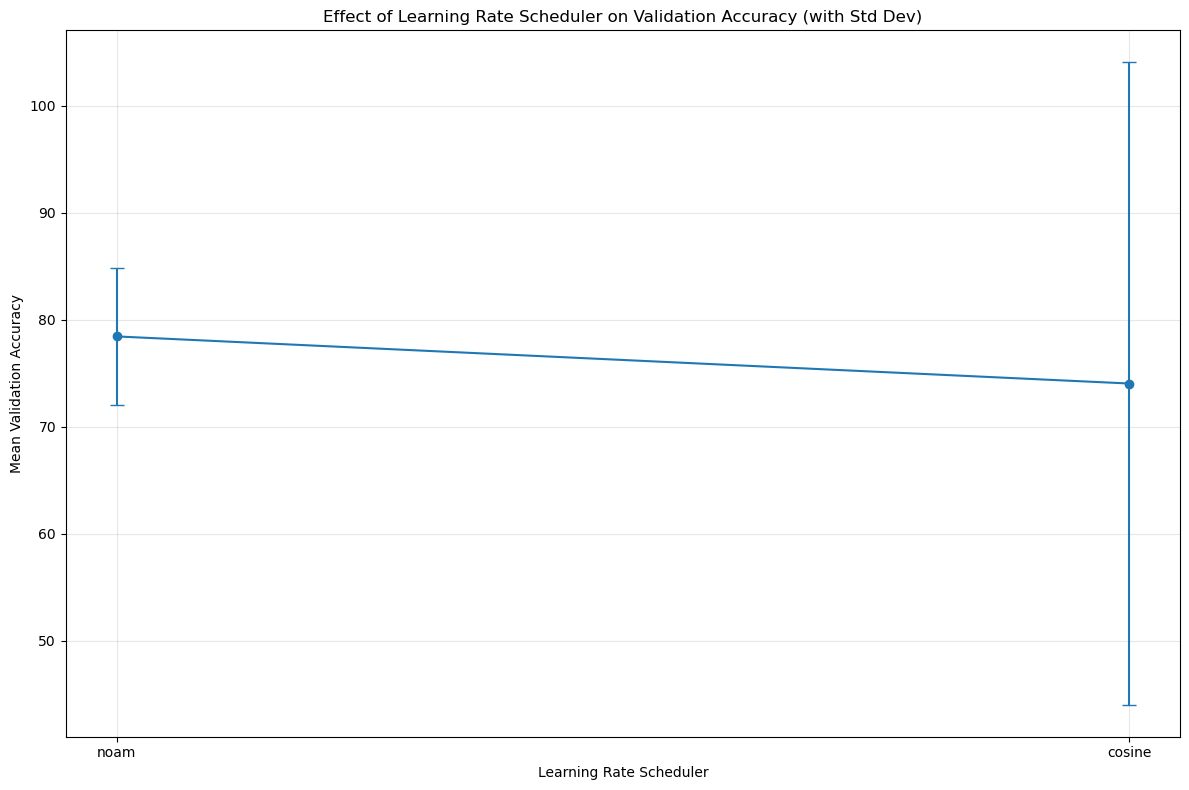

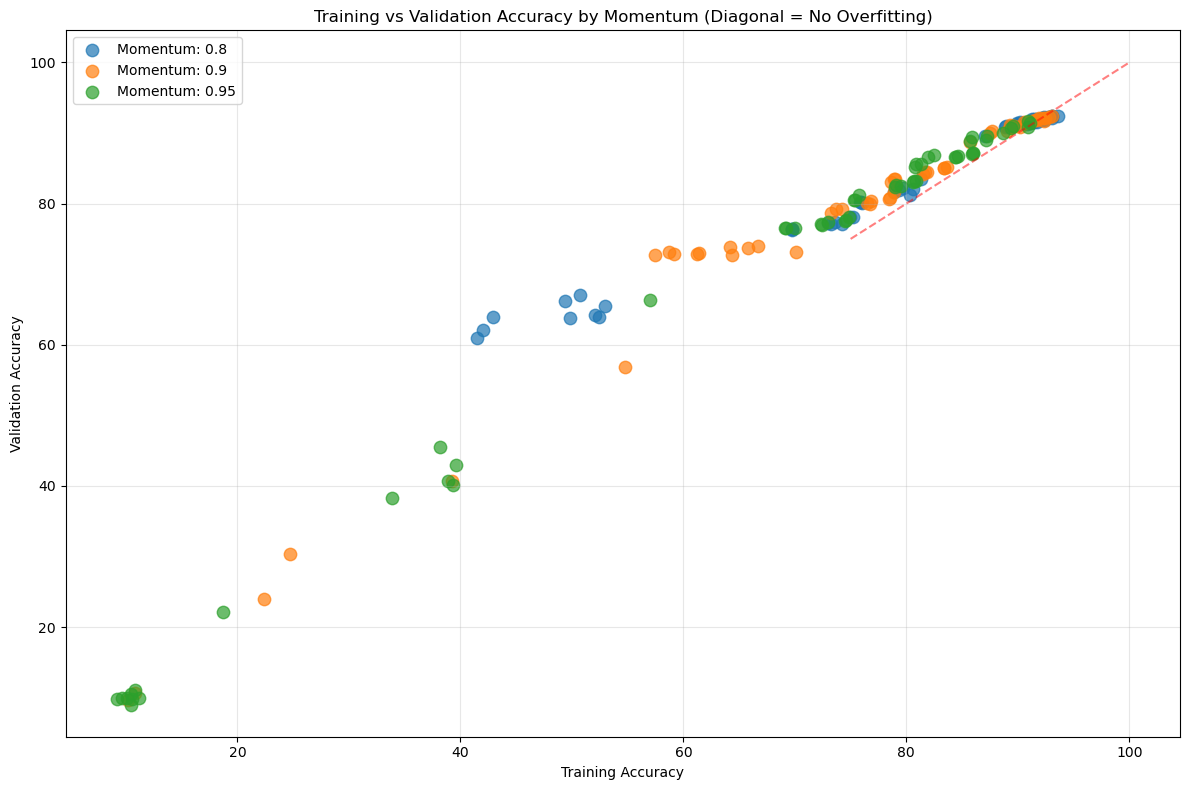

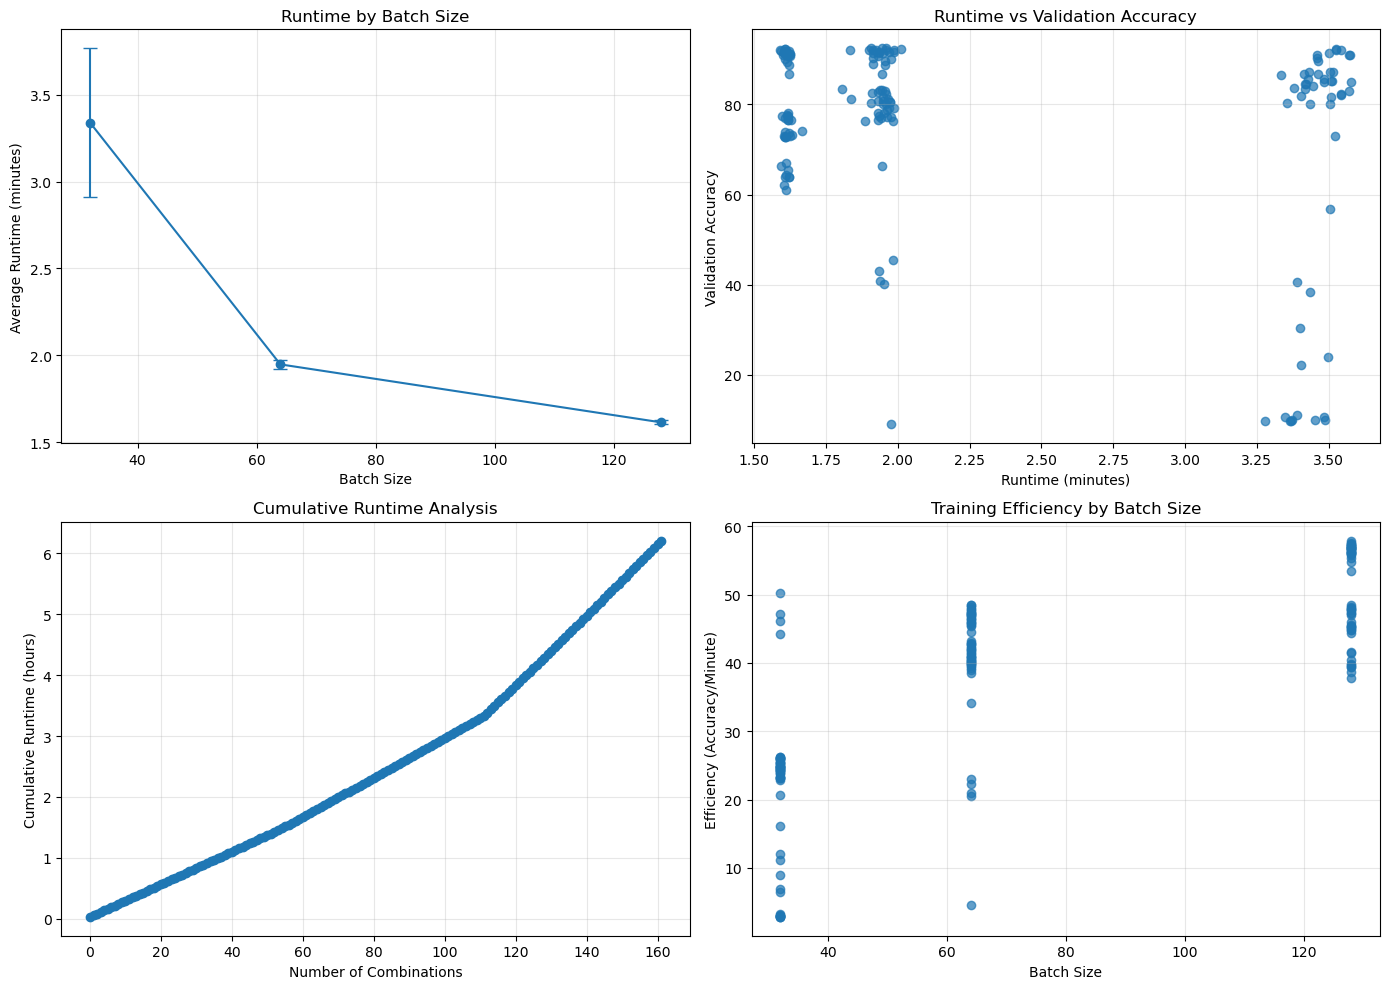

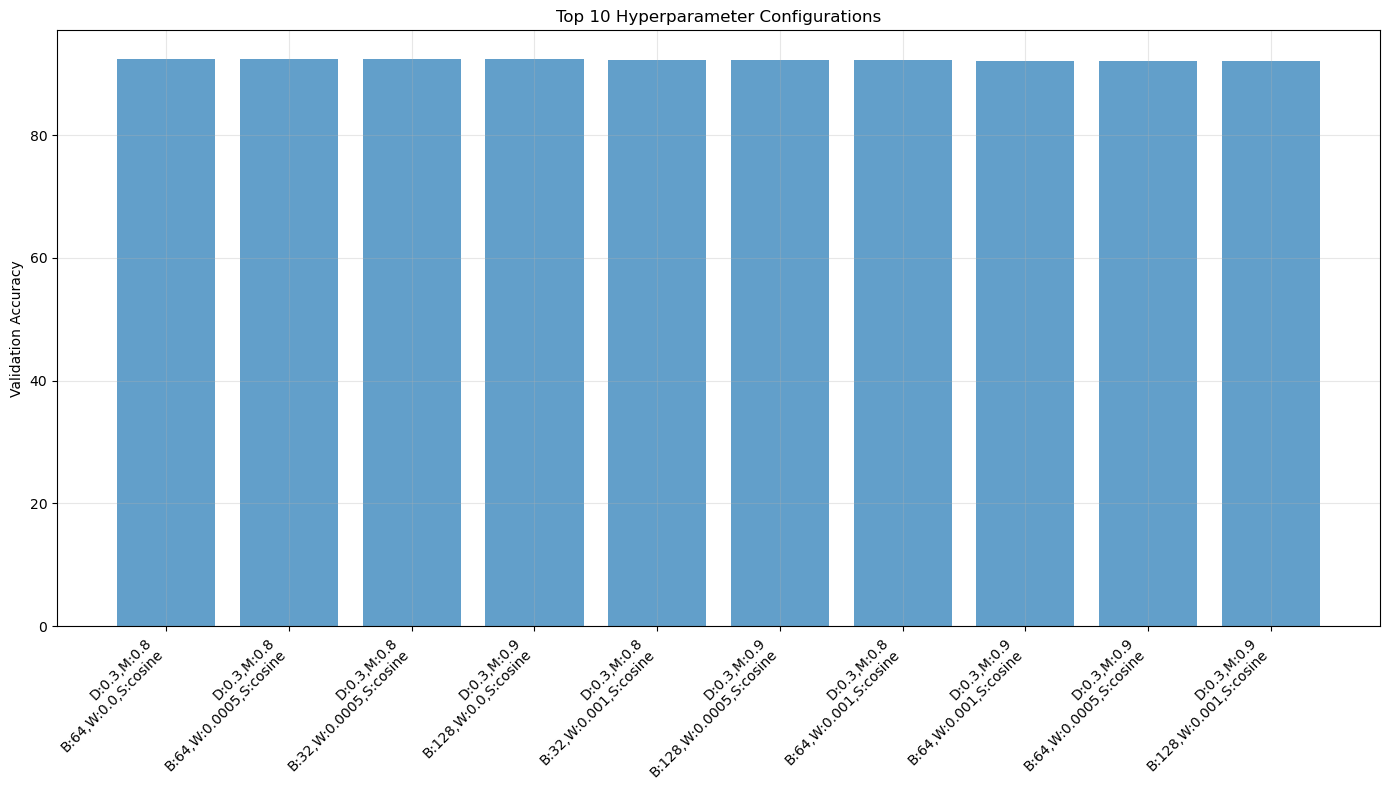

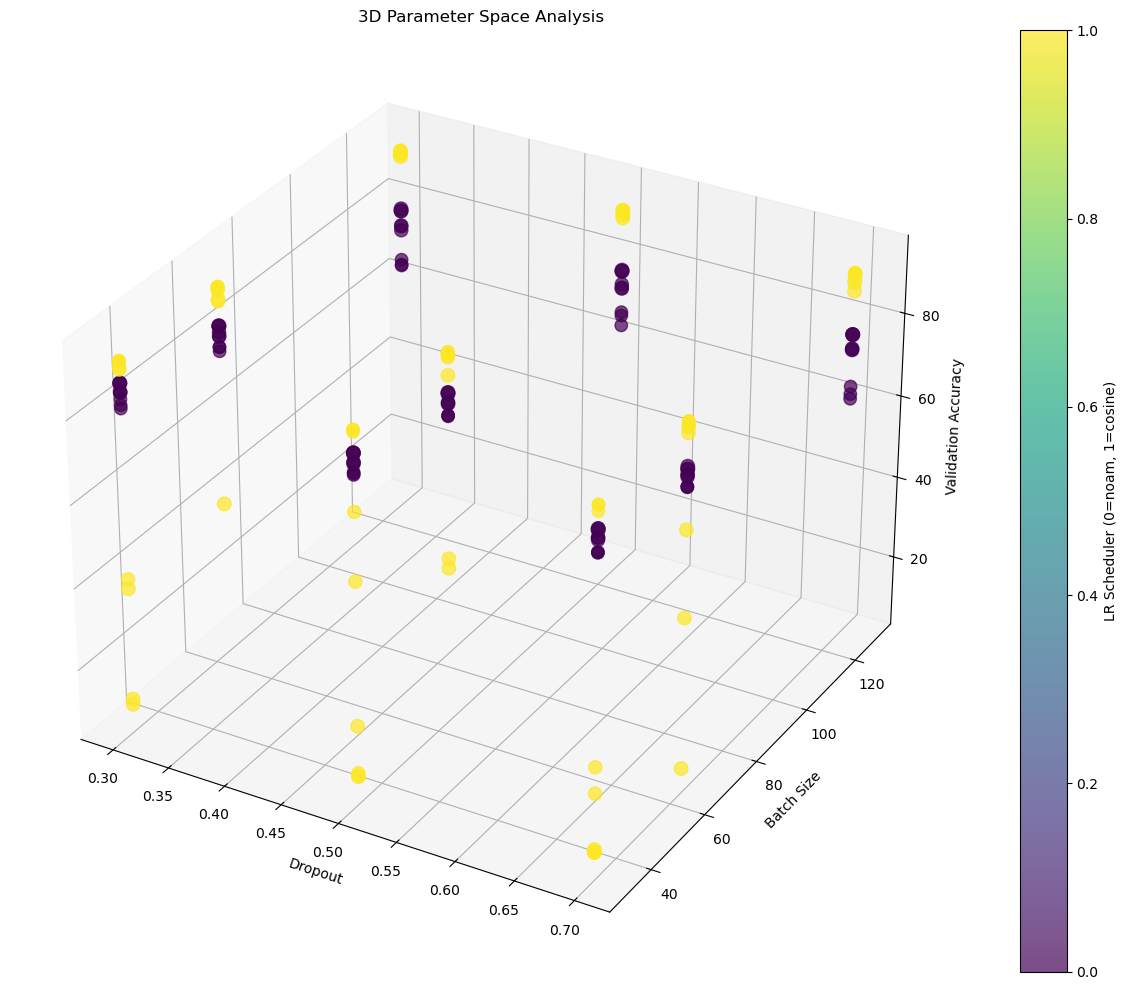

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import os
import datetime
import pandas as pd
import seaborn as sns
import time

# Create plots directory if it doesn't exist
os.makedirs("plots", exist_ok=True)

print("Loading data")

# Load the FashionMNIST data
def get_fashionmnist_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    return dataset

# Define the Simple CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128), nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

# Noam Learning Rate Scheduler
def noam_lr_schedule(step, d_model=512, warmup=4000):
    return d_model ** -0.5 * min(step ** -0.5, step * warmup ** -1.5)

# Cosine Learning Rate Scheduler
def cosine_lr_schedule(t, eta_max, T, T0):
    if t <= T0:
        return 1e-4 + (eta_max - 1e-4) * (t / T0)
    return eta_max * np.cos((math.pi / 2) * ((t - T0) / (T - T0))) + 1e-6

# Train and Validate the Model
def train_and_validate(train_loader, val_loader, model, optimizer, scheduler_fn, epochs=5):  # Original epochs = 5
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.CrossEntropyLoss()

    train_acc, val_acc = [], []
    train_loss, val_loss = [], []
    global_step = 0
    T = epochs * len(train_loader)
    T0 = T // 5

    # Setup for mixed precision training if available
    if device.type == 'cuda' and torch.cuda.is_available() and hasattr(torch.cuda, 'amp'):
        use_amp = True
        scaler = torch.cuda.amp.GradScaler()
    else:
        use_amp = False

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            global_step += 1
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            
            # Use mixed precision training if available
            if use_amp:
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            # LR scheduling
            lr = scheduler_fn(global_step, T, T0)
            optimizer.param_groups[0]['lr'] = lr

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc.append(100 * correct / total)
        train_loss.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss_epoch, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                if use_amp:
                    with torch.cuda.amp.autocast():
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                else:
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    
                val_loss_epoch += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc.append(100 * correct / total)
        val_loss.append(val_loss_epoch / len(val_loader))

    return train_acc, train_loss, val_acc, val_loss

# Cross-validation for hyperparameter tuning
def cross_validate_model(dataset, model_fn, params, k_folds=5, epochs=5):  # Original k_folds = 5, epochs = 5
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    kfold = KFold(n_splits=k_folds, shuffle=True)
    results = {}

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        fold_start_time = time.time()
        print(f"Training fold {fold+1}/{k_folds}...")

        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Performance optimization: Use more workers for data loading
        num_workers = 4 if torch.cuda.is_available() else 0
        train_loader = DataLoader(train_subset, batch_size=params['batch_size'], shuffle=True, 
                                 num_workers=num_workers, pin_memory=True if torch.cuda.is_available() else False,
                                 persistent_workers=True if num_workers > 0 else False)
        val_loader = DataLoader(val_subset, batch_size=params['batch_size']*2, shuffle=False,  # Double batch size for validation
                               num_workers=num_workers, pin_memory=True if torch.cuda.is_available() else False,
                               persistent_workers=True if num_workers > 0 else False)

        model = model_fn(dropout=params['dropout']).to(device)
            
        optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=params['momentum'], weight_decay=params['weight_decay'])

        if params['lr_scheduler'] == 'noam':
            scheduler_fn = lambda step, *_: noam_lr_schedule(step)
        else:
            scheduler_fn = lambda step, T, T0: cosine_lr_schedule(step, eta_max=0.1, T=T, T0=T0)

        train_acc, train_loss, val_acc, val_loss = train_and_validate(
            train_loader, val_loader, model, optimizer, scheduler_fn, epochs
        )

        fold_end_time = time.time()
        fold_duration = (fold_end_time - fold_start_time) / 60  # minutes
        print(f"Fold {fold+1} completed in {fold_duration:.2f} minutes")

        results[fold] = {
            'train_acc': train_acc,
            'train_loss': train_loss,
            'val_acc': val_acc,
            'val_loss': val_loss,
            'duration': fold_duration
        }

    return results

# Grid Search with Batch Size and Other Parameters
def grid_search(dataset, model_fn, param_grid, k_folds=5, epochs=5):  # Original k_folds = 5, epochs = 5
    best_params = None
    best_val_acc = 0

    # Create a list to store all results for visualization
    results_data = []
    
    # For timing information
    total_combinations = (len(param_grid['dropout']) * len(param_grid['momentum']) * 
                         len(param_grid['batch_size']) * len(param_grid['weight_decay']) * 
                         len(param_grid['lr_scheduler']))
    print(f"Total combinations to evaluate: {total_combinations}")
    
    combination_count = 0
    start_time = time.time()

    # Save configuration details
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    with open(f"plots/experiment_config_{timestamp}.txt", "w") as f:
        f.write(f"Experiment started at: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Parameter grid: {param_grid}\n")
        f.write(f"K-folds: {k_folds}\n")
        f.write(f"Epochs: {epochs}\n")
        f.write(f"Total combinations: {total_combinations}\n")
        f.write(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}\n")
        if torch.cuda.is_available():
            f.write(f"GPU: {torch.cuda.get_device_name(0)}\n")
            f.write(f"CUDA Version: {torch.version.cuda}\n")

    for dropout in param_grid['dropout']:
        for momentum in param_grid['momentum']:
            for batch_size in param_grid['batch_size']:
                for weight_decay in param_grid['weight_decay']:
                    for lr_scheduler in param_grid['lr_scheduler']:
                        combination_start_time = time.time()
                        combination_count += 1
                        
                        params = {
                            'dropout': dropout,
                            'momentum': momentum,
                            'batch_size': batch_size,
                            'weight_decay': weight_decay,
                            'lr_scheduler': lr_scheduler
                        }

                        print(f"\n=== Evaluating combination {combination_count}/{total_combinations} ===")
                        print(f"Parameters: {params}")

                        results = cross_validate_model(dataset, model_fn, params, k_folds, epochs)

                        avg_val_acc = np.mean([results[fold]['val_acc'][-1] for fold in range(k_folds)])
                        avg_train_acc = np.mean([results[fold]['train_acc'][-1] for fold in range(k_folds)])
                        avg_train_loss = np.mean([results[fold]['train_loss'][-1] for fold in range(k_folds)])
                        avg_val_loss = np.mean([results[fold]['val_loss'][-1] for fold in range(k_folds)])
                        avg_fold_duration = np.mean([results[fold]['duration'] for fold in range(k_folds)])
                        
                        # Calculate overfitting (train_acc - val_acc)
                        overfitting = avg_train_acc - avg_val_acc

                        combination_end_time = time.time()
                        combination_duration = (combination_end_time - combination_start_time) / 60  # minutes
                        
                        # Estimate remaining time
                        elapsed_time = (time.time() - start_time) / 3600  # hours
                        estimated_total_time = elapsed_time * total_combinations / combination_count
                        estimated_remaining_time = estimated_total_time - elapsed_time
                        
                        print(f"Combination {combination_count}/{total_combinations} completed in {combination_duration:.2f} minutes")
                        print(f"Avg Training Accuracy: {avg_train_acc:.2f}%, Avg Validation Accuracy: {avg_val_acc:.2f}%")
                        print(f"Elapsed time: {elapsed_time:.2f} hours, Estimated remaining: {estimated_remaining_time:.2f} hours")
                        print(f"Estimated completion at: {(datetime.datetime.now() + datetime.timedelta(hours=estimated_remaining_time)).strftime('%Y-%m-%d %H:%M:%S')}")

                        # Store the results for visualization
                        results_data.append({
                            'dropout': dropout,
                            'momentum': momentum,
                            'batch_size': batch_size,
                            'weight_decay': weight_decay,
                            'lr_scheduler': lr_scheduler,
                            'val_acc': avg_val_acc,
                            'train_acc': avg_train_acc,
                            'train_loss': avg_train_loss,
                            'val_loss': avg_val_loss,
                            'overfitting': overfitting,
                            'runtime_minutes': combination_duration,
                            'avg_fold_duration': avg_fold_duration
                        })
                        
                        # Save intermediate results after each combination
                        intermediate_df = pd.DataFrame(results_data)
                        intermediate_df.to_csv(f"plots/intermediate_results_{timestamp}.csv", index=False)
                        
                        # Create a checkpoint of current progress
                        with open(f"plots/progress_checkpoint_{timestamp}.txt", "a") as f:
                            f.write(f"Combination {combination_count}/{total_combinations}: {params}\n")
                            f.write(f"Val Acc: {avg_val_acc:.2f}%, Train Acc: {avg_train_acc:.2f}%, Overfitting: {overfitting:.2f}%\n")
                            f.write(f"Runtime: {combination_duration:.2f} minutes\n")
                            f.write(f"Elapsed time: {elapsed_time:.2f} hours, Remaining: {estimated_remaining_time:.2f} hours\n")
                            f.write("-" * 50 + "\n")

                        if avg_val_acc > best_val_acc:
                            best_val_acc = avg_val_acc
                            best_params = params
                            print(f"New best parameters found: {best_params} with validation accuracy: {best_val_acc:.2f}%")
                            # Save best parameters immediately
                            with open(f"plots/best_params_{timestamp}.txt", "w") as f:
                                f.write(f"Best parameters as of combination {combination_count}/{total_combinations}:\n")
                                f.write(f"Parameters: {best_params}\n")
                                f.write(f"Validation Accuracy: {best_val_acc:.2f}%\n")
                                f.write(f"Found at: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

    print(f"Best Params: {best_params}")
    
    # Convert results to DataFrame for easier visualization
    results_df = pd.DataFrame(results_data)
    
    return best_params, results_df

# Visualization functions
def create_visualizations(results_df, timestamp):
    """Create various visualizations to understand hyperparameter effects"""
    
    # 1. Heatmap of batch size vs dropout effect on validation accuracy
    plt.figure(figsize=(12, 8))
    pivot_table = results_df.pivot_table(
        values='val_acc', 
        index='dropout', 
        columns='batch_size', 
        aggfunc='mean'
    )
    sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt='.2f')
    plt.title('Effect of Dropout and Batch Size on Validation Accuracy')
    plt.tight_layout()
    plt.savefig(f"plots/heatmap_dropout_batchsize_{timestamp}.png", dpi=300)
    
    # 2. Scatter plot of batch size vs validation accuracy colored by dropout
    plt.figure(figsize=(12, 8))
    for dropout in results_df['dropout'].unique():
        subset = results_df[results_df['dropout'] == dropout]
        plt.scatter(subset['batch_size'], subset['val_acc'], 
                   label=f'Dropout: {dropout}', alpha=0.7, s=80)
    plt.xlabel('Batch Size')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy by Batch Size and Dropout')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"plots/scatter_batchsize_accuracy_{timestamp}.png", dpi=300)
    
    # 3. Weight decay effect with error bars
    plt.figure(figsize=(12, 8))
    weight_decay_data = []
    for wd in results_df['weight_decay'].unique():
        wd_subset = results_df[results_df['weight_decay'] == wd]
        weight_decay_data.append({
            'weight_decay': wd,
            'mean_val_acc': wd_subset['val_acc'].mean(),
            'std_val_acc': wd_subset['val_acc'].std()
        })
    wd_df = pd.DataFrame(weight_decay_data)
    plt.errorbar(wd_df['weight_decay'], wd_df['mean_val_acc'], yerr=wd_df['std_val_acc'], fmt='o-', capsize=5)
    plt.xlabel('Weight Decay')
    plt.ylabel('Mean Validation Accuracy')
    plt.title('Effect of Weight Decay on Validation Accuracy (with Std Dev)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"plots/errorbar_weightdecay_{timestamp}.png", dpi=300)
    
    # 4. Compare scheduler effects with error bars
    plt.figure(figsize=(12, 8))
    scheduler_data = []
    for scheduler in results_df['lr_scheduler'].unique():
        scheduler_subset = results_df[results_df['lr_scheduler'] == scheduler]
        scheduler_data.append({
            'lr_scheduler': scheduler,
            'mean_val_acc': scheduler_subset['val_acc'].mean(),
            'std_val_acc': scheduler_subset['val_acc'].std()
        })
    scheduler_df = pd.DataFrame(scheduler_data)
    plt.errorbar(range(len(scheduler_df)), scheduler_df['mean_val_acc'], yerr=scheduler_df['std_val_acc'], fmt='o-', capsize=5)
    plt.xticks(range(len(scheduler_df)), scheduler_df['lr_scheduler'])
    plt.xlabel('Learning Rate Scheduler')
    plt.ylabel('Mean Validation Accuracy')
    plt.title('Effect of Learning Rate Scheduler on Validation Accuracy (with Std Dev)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"plots/errorbar_scheduler_{timestamp}.png", dpi=300)
    
    # 5. Overfitting analysis with coloring by momentum
    plt.figure(figsize=(12, 8))
    for momentum in results_df['momentum'].unique():
        subset = results_df[results_df['momentum'] == momentum]
        plt.scatter(subset['train_acc'], subset['val_acc'], alpha=0.7, s=80, label=f'Momentum: {momentum}')
    plt.plot([75, 100], [75, 100], 'r--', alpha=0.5)  # Diagonal line
    plt.xlabel('Training Accuracy')
    plt.ylabel('Validation Accuracy')
    plt.title('Training vs Validation Accuracy by Momentum (Diagonal = No Overfitting)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"plots/overfitting_by_momentum_{timestamp}.png", dpi=300)
    
    # 6. Runtime analysis
    plt.figure(figsize=(14, 10))
    
    # Plot runtime vs batch size
    plt.subplot(2, 2, 1)
    runtime_by_batch = results_df.groupby('batch_size')['runtime_minutes'].mean().reset_index()
    runtime_by_batch_std = results_df.groupby('batch_size')['runtime_minutes'].std().reset_index()
    plt.errorbar(runtime_by_batch['batch_size'], runtime_by_batch['runtime_minutes'], 
                yerr=runtime_by_batch_std['runtime_minutes'], fmt='o-', capsize=5)
    plt.xlabel('Batch Size')
    plt.ylabel('Average Runtime (minutes)')
    plt.title('Runtime by Batch Size')
    plt.grid(True, alpha=0.3)
    
    # Plot runtime vs accuracy
    plt.subplot(2, 2, 2)
    plt.scatter(results_df['runtime_minutes'], results_df['val_acc'], alpha=0.7)
    plt.xlabel('Runtime (minutes)')
    plt.ylabel('Validation Accuracy')
    plt.title('Runtime vs Validation Accuracy')
    plt.grid(True, alpha=0.3)
    
    # Plot total training time analysis
    plt.subplot(2, 2, 3)
    sorted_runtime = results_df.sort_values('runtime_minutes')
    plt.plot(range(len(sorted_runtime)), np.cumsum(sorted_runtime['runtime_minutes'])/60, 'o-')
    plt.xlabel('Number of Combinations')
    plt.ylabel('Cumulative Runtime (hours)')
    plt.title('Cumulative Runtime Analysis')
    plt.grid(True, alpha=0.3)
    
    # Plot accuracy vs training efficiency
    plt.subplot(2, 2, 4)
    results_df['efficiency'] = results_df['val_acc'] / results_df['runtime_minutes']
    plt.scatter(results_df['batch_size'], results_df['efficiency'], alpha=0.7)
    plt.xlabel('Batch Size')
    plt.ylabel('Efficiency (Accuracy/Minute)')
    plt.title('Training Efficiency by Batch Size')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"plots/runtime_analysis_{timestamp}.png", dpi=300)
    
    # 7. Top 10 configurations
    top_10 = results_df.sort_values('val_acc', ascending=False).head(10)
    plt.figure(figsize=(14, 8))
    
    # Create labels for x-axis
    x_labels = []
    for _, row in top_10.iterrows():
        label = f"D:{row['dropout']},M:{row['momentum']}\nB:{row['batch_size']},W:{row['weight_decay']},S:{row['lr_scheduler']}"
        x_labels.append(label)
    
    # Create the bar plot
    bars = plt.bar(range(len(top_10)), top_10['val_acc'], alpha=0.7)
    plt.xticks(range(len(top_10)), x_labels, rotation=45, ha='right')
    plt.ylabel('Validation Accuracy')
    plt.title('Top 10 Hyperparameter Configurations')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"plots/top10_configurations_{timestamp}.png", dpi=300)
    
    # 8. Interactive parameter analysis - 3D plot
    try:
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(14, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # Convert categorical variables to numeric for plotting
        results_df['lr_scheduler_num'] = results_df['lr_scheduler'].map({'noam': 0, 'cosine': 1})
        
        scatter = ax.scatter(
            results_df['dropout'], 
            results_df['batch_size'], 
            results_df['val_acc'],
            c=results_df['lr_scheduler_num'], 
            s=results_df['momentum'] * 100,  # Size by momentum
            alpha=0.7
        )
        
        ax.set_xlabel('Dropout')
        ax.set_ylabel('Batch Size')
        ax.set_zlabel('Validation Accuracy')
        plt.colorbar(scatter, label='LR Scheduler (0=noam, 1=cosine)')
        plt.title('3D Parameter Space Analysis')
        plt.tight_layout()
        plt.savefig(f"plots/3d_parameter_analysis_{timestamp}.png", dpi=300)
    except:
        print("Could not create 3D plot, skipping...")

    print(f"Visualizations saved in plots/ directory with timestamp {timestamp}")

# Run the Experiment
def run_experiment():
    # Track total execution time
    total_start_time = time.time()
    
    dataset = get_fashionmnist_data()

    # Use the original parameter grid
    param_grid = {
        'dropout': [0.3, 0.5, 0.7],
        'momentum': [0.8, 0.9, 0.95],
        'batch_size': [32, 64, 128],
        'weight_decay': [0.0, 0.0005, 0.001],
        'lr_scheduler': ['noam', 'cosine']
    }

    # Generate timestamp for file naming
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    
    print("Starting grid search")
    print(f"Running with original complexity: k_folds=5, epochs=5")
    
    # Keep original k_folds and epochs
    best_params, results_df = grid_search(dataset, SimpleCNN, param_grid, k_folds=5, epochs=5)
    
    total_end_time = time.time()
    total_execution_time = (total_end_time - total_start_time) / 3600  # hours
    
    print(f"Grid search completed in {total_execution_time:.2f} hours")
    print(f"Best Hyperparameters: {best_params}")
    
    # Create visualizations
    create_visualizations(results_df, timestamp)
    
    # Save the full results dataframe for later analysis
    results_df.to_csv(f"plots/hyperparameter_results_{timestamp}.csv", index=False)
    
    # Save summary information
    with open(f"plots/experiment_summary_{timestamp}.txt", "w") as f:
        f.write(f"Experiment completed at: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Total execution time: {total_execution_time:.2f} hours\n")
        f.write(f"Best parameters: {best_params}\n")
        f.write(f"Best validation accuracy: {results_df.sort_values('val_acc', ascending=False).iloc[0]['val_acc']:.2f}%\n\n")
        
        f.write("==== Parameter Analysis ====\n")
        
        # Analysis by dropout
        f.write("\nAnalysis by Dropout:\n")
        dropout_analysis = results_df.groupby('dropout')['val_acc'].agg(['mean', 'std', 'max']).reset_index()
        for _, row in dropout_analysis.iterrows():
            f.write(f"Dropout {row['dropout']}: Mean={row['mean']:.2f}%, Std={row['std']:.2f}%, Max={row['max']:.2f}%\n")
            
        # Analysis by batch size
        f.write("\nAnalysis by Batch Size:\n")
        batch_analysis = results_df.groupby('batch_size')['val_acc'].agg(['mean', 'std', 'max']).reset_index()
        for _, row in batch_analysis.iterrows():
            f.write(f"Batch Size {row['batch_size']}: Mean={row['mean']:.2f}%, Std={row['std']:.2f}%, Max={row['max']:.2f}%\n")
            
        # Analysis by weight decay
        f.write("\nAnalysis by Weight Decay:\n")
        wd_analysis = results_df.groupby('weight_decay')['val_acc'].agg(['mean', 'std', 'max']).reset_index()
        for _, row in wd_analysis.iterrows():
            f.write(f"Weight Decay {row['weight_decay']}: Mean={row['mean']:.2f}%, Std={row['std']:.2f}%, Max={row['max']:.2f}%\n")
            
        # Analysis by scheduler
        f.write("\nAnalysis by LR Scheduler:\n")
        scheduler_analysis = results_df.groupby('lr_scheduler')['val_acc'].agg(['mean', 'std', 'max']).reset_index()
        for _, row in scheduler_analysis.iterrows():
            f.write(f"Scheduler {row['lr_scheduler']}: Mean={row['mean']:.2f}%, Std={row['std']:.2f}%, Max={row['max']:.2f}%\n")
            
        # Top 5 configurations
        f.write("\nTop 5 Configurations:\n")
        top_5 = results_df.sort_values('val_acc', ascending=False).head(5)
        for i, row in enumerate(top_5.itertuples()):
            f.write(f"{i+1}. Dropout={row.dropout}, Momentum={row.momentum}, Batch Size={row.batch_size}, ")
            f.write(f"Weight Decay={row.weight_decay}, LR Scheduler={row.lr_scheduler}, ")
            f.write(f"Val Acc={row.val_acc:.2f}%, Runtime={row.runtime_minutes:.2f} minutes\n")
    
    print(f"All results saved. Total execution time: {total_execution_time:.2f} hours")
    print(f"Check plots/ directory for visualizations and detailed results")

if __name__ == '__main__':
    run_experiment()

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import math
from matplotlib.gridspec import GridSpec
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# Set plot style for better visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

def create_visualization_directory():
    """Create directory for visualizations if it doesn't exist"""
    import os
    vis_dir = "ml_concept_visualizations"
    os.makedirs(vis_dir, exist_ok=True)
    return vis_dir

vis_dir = create_visualization_directory()

# 1. L2 Regularization Visualization
def visualize_l2_regularization():
    """
    Visualize how L2 regularization affects weight updates and model complexity.
    """
    # Simple toy model for visualization
    class SimpleModel(nn.Module):
        def __init__(self):
            super(SimpleModel, self).__init__()
            self.linear = nn.Linear(2, 1)
            
        def forward(self, x):
            return self.linear(x)
    
    # Create two identical models
    torch.manual_seed(42)
    model_no_reg = SimpleModel()
    model_with_reg = SimpleModel()
    
    # Initialize with same weights
    initial_weights = torch.randn(1, 2)
    initial_bias = torch.zeros(1)
    with torch.no_grad():
        model_no_reg.linear.weight = nn.Parameter(initial_weights.clone())
        model_no_reg.linear.bias = nn.Parameter(initial_bias.clone())
        model_with_reg.linear.weight = nn.Parameter(initial_weights.clone())
        model_with_reg.linear.bias = nn.Parameter(initial_bias.clone())
    
    # Create optimizers (note the weight_decay parameter for L2)
    optimizer_no_reg = optim.SGD(model_no_reg.parameters(), lr=0.1)
    optimizer_with_reg = optim.SGD(model_with_reg.parameters(), lr=0.1, weight_decay=0.1)
    
    # Mock data
    X = torch.randn(100, 2)
    y = 2 * X[:, 0] - X[:, 1] + torch.randn(100) * 0.1
    
    # Training loop
    criterion = nn.MSELoss()
    epochs = 100
    weight_history_no_reg = []
    weight_history_with_reg = []
    
    for epoch in range(epochs):
        # No regularization
        optimizer_no_reg.zero_grad()
        output_no_reg = model_no_reg(X)
        loss_no_reg = criterion(output_no_reg, y.unsqueeze(1))
        loss_no_reg.backward()
        optimizer_no_reg.step()
        weight_history_no_reg.append(model_no_reg.linear.weight.detach().clone().numpy().flatten())
        
        # With L2 regularization
        optimizer_with_reg.zero_grad()
        output_with_reg = model_with_reg(X)
        loss_with_reg = criterion(output_with_reg, y.unsqueeze(1))
        loss_with_reg.backward()
        optimizer_with_reg.step()
        weight_history_with_reg.append(model_with_reg.linear.weight.detach().clone().numpy().flatten())
    
    # Convert to numpy arrays for easier plotting
    weight_history_no_reg = np.array(weight_history_no_reg)
    weight_history_with_reg = np.array(weight_history_with_reg)
    
    # Plot weight trajectories
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Weight magnitudes
    axes[0].plot(np.linalg.norm(weight_history_no_reg, axis=1), label='Without L2')
    axes[0].plot(np.linalg.norm(weight_history_with_reg, axis=1), label='With L2')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Weight Magnitude (L2 Norm)')
    axes[0].set_title('Effect of L2 Regularization on Weight Magnitude')
    axes[0].legend()
    
    # Weight paths in 2D
    axes[1].plot(weight_history_no_reg[:, 0], weight_history_no_reg[:, 1], 'o-', 
                 label='Without L2', alpha=0.6, markersize=4)
    axes[1].plot(weight_history_with_reg[:, 0], weight_history_with_reg[:, 1], 'o-', 
                 label='With L2', alpha=0.6, markersize=4)
    axes[1].set_xlabel('Weight 1')
    axes[1].set_ylabel('Weight 2')
    axes[1].set_title('Weight Trajectories During Training')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig(f"{vis_dir}/l2_regularization.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Plot contour of loss landscape with and without regularization
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Create a grid of weight values
    w1 = np.linspace(-3, 3, 100)
    w2 = np.linspace(-3, 3, 100)
    W1, W2 = np.meshgrid(w1, w2)
    
    # Compute loss for each weight configuration
    Z_no_reg = np.zeros_like(W1)
    Z_with_reg = np.zeros_like(W1)
    
    X_numpy = X.numpy()
    y_numpy = y.numpy()
    
    for i in range(len(w1)):
        for j in range(len(w2)):
            # Model prediction
            pred = X_numpy @ np.array([W1[i, j], W2[i, j]]) 
            
            # MSE Loss
            mse = np.mean((pred - y_numpy) ** 2)
            
            # Loss without regularization
            Z_no_reg[i, j] = mse
            
            # Loss with L2 regularization
            l2_penalty = 0.1 * (W1[i, j]**2 + W2[i, j]**2)
            Z_with_reg[i, j] = mse + l2_penalty
    
    # Plot contours
    contour_no_reg = axes[0].contourf(W1, W2, Z_no_reg, 50, cmap='viridis')
    axes[0].plot(weight_history_no_reg[:, 0], weight_history_no_reg[:, 1], 'r-', linewidth=2)
    axes[0].set_xlabel('Weight 1')
    axes[0].set_ylabel('Weight 2')
    axes[0].set_title('Loss Landscape Without L2')
    plt.colorbar(contour_no_reg, ax=axes[0])
    
    contour_with_reg = axes[1].contourf(W1, W2, Z_with_reg, 50, cmap='viridis')
    axes[1].plot(weight_history_with_reg[:, 0], weight_history_with_reg[:, 1], 'r-', linewidth=2)
    axes[1].set_xlabel('Weight 1')
    axes[1].set_ylabel('Weight 2')
    axes[1].set_title('Loss Landscape With L2')
    plt.colorbar(contour_with_reg, ax=axes[1])
    
    plt.tight_layout()
    plt.savefig(f"{vis_dir}/l2_regularization_landscape.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    print("L2 Regularization visualizations saved!")

# 2. Learning Rate Schedulers Visualization
def visualize_learning_rate_schedulers():
    """
    Visualize different learning rate schedulers and their impact on training.
    """
    # Define different learning rate schedulers
    def constant_lr(step, initial_lr=0.01):
        return initial_lr
    
    def step_decay_lr(step, initial_lr=0.1, drop_factor=0.5, epochs_drop=10):
        return initial_lr * (drop_factor ** (step // epochs_drop))
    
    def exponential_decay_lr(step, initial_lr=0.1, decay_rate=0.9):
        return initial_lr * decay_rate ** step
    
    def cosine_annealing_lr(step, initial_lr=0.1, T_max=100):
        return initial_lr * (1 + math.cos(math.pi * step / T_max)) / 2
    
    def noam_lr(step, d_model=512, warmup=4000):
        return d_model ** -0.5 * min(step ** -0.5, step * warmup ** -1.5)
    
    # Generate learning rates for each scheduler
    steps = np.arange(1, 101)
    constant_lrs = [constant_lr(step) for step in steps]
    step_decay_lrs = [step_decay_lr(step) for step in steps]
    exp_decay_lrs = [exponential_decay_lr(step) for step in steps]
    cosine_lrs = [cosine_annealing_lr(step) for step in steps]
    
    # For Noam, scale steps to show more typical behavior (similar to script)
    noam_steps = np.arange(1, 10001)
    noam_lrs = [noam_lr(step) for step in noam_steps]
    
    # Plot learning rate schedules
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Basic schedulers
    axes[0].plot(steps, constant_lrs, label='Constant')
    axes[0].plot(steps, step_decay_lrs, label='Step Decay')
    axes[0].plot(steps, exp_decay_lrs, label='Exponential Decay')
    axes[0].plot(steps, cosine_lrs, label='Cosine Annealing')
    axes[0].set_xlabel('Training Steps')
    axes[0].set_ylabel('Learning Rate')
    axes[0].set_title('Common Learning Rate Schedulers')
    axes[0].legend()
    axes[0].grid(True)
    
    # Noam scheduler from Transformer paper
    axes[1].plot(noam_steps, noam_lrs)
    axes[1].set_xlabel('Training Steps')
    axes[1].set_ylabel('Learning Rate')
    axes[1].set_title('Noam Scheduler (from "Attention is All You Need")')
    axes[1].set_xscale('log')
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig(f"{vis_dir}/learning_rate_schedulers.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Simulate training with different schedulers
    np.random.seed(42)
    
    # Mock loss function (quadratic with noise) decreasing over time
    def mock_training(lr_schedule, steps=100, noise_level=0.1):
        losses = []
        
        # Starting point far from minimum
        x = 10.0
        
        for step in range(1, steps + 1):
            # Quadratic loss function with minimum at x=0
            loss = x ** 2
            losses.append(loss)
            
            # Gradient of loss is 2x
            gradient = 2 * x
            
            # Add some noise to the gradient
            gradient += np.random.normal(0, noise_level * abs(gradient))
            
            # Update x using the learning rate from the scheduler
            lr = lr_schedule(step)
            x = x - lr * gradient
        
        return losses
    
    # Run simulated training with each scheduler
    constant_losses = mock_training(constant_lr)
    step_losses = mock_training(step_decay_lr)
    exp_losses = mock_training(exponential_decay_lr)
    cosine_losses = mock_training(cosine_annealing_lr)
    
    # Define and run Noam scheduler for the same number of steps
    noam_for_sim = lambda step: noam_lr(step, warmup=20)
    noam_losses = mock_training(noam_for_sim)
    
    # Plot training convergence
    plt.figure(figsize=(12, 8))
    plt.plot(steps, constant_losses, label='Constant')
    plt.plot(steps, step_losses, label='Step Decay')
    plt.plot(steps, exp_losses, label='Exponential Decay')
    plt.plot(steps, cosine_losses, label='Cosine Annealing')
    plt.plot(steps, noam_losses, label='Noam (Transformer)')
    
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Training Convergence with Different Learning Rate Schedulers')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    
    plt.tight_layout()
    plt.savefig(f"{vis_dir}/scheduler_convergence.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    print("Learning Rate Scheduler visualizations saved!")

# 3. Warmup Phase Visualization
def visualize_warmup_phase():
    """
    Visualize the warmup phase in learning rate schedulers and its impact.
    """
    # Define learning rate schedulers with different warmup periods
    def cosine_with_warmup(step, max_lr=0.1, total_steps=100, warmup_steps=0):
        if step < warmup_steps:
            return max_lr * (step / warmup_steps)
        else:
            # Cosine decay from max_lr to 0
            decay_steps = total_steps - warmup_steps
            decay_step = step - warmup_steps
            cosine_decay = 0.5 * (1 + math.cos(math.pi * decay_step / decay_steps))
            return max_lr * cosine_decay
    
    # Noam scheduler from "Attention is All You Need"
    def noam_lr(step, d_model=512, warmup=4000):
        factor = d_model ** -0.5
        return factor * min(step ** -0.5, step * warmup ** -1.5)
    
    steps = np.arange(1, 101)
    total_steps = 100
    
    # Generate warmup schedules with different warmup lengths
    warmup_lengths = [0, 10, 20, 50]
    cosine_schedules = []
    
    for warmup in warmup_lengths:
        schedule = [cosine_with_warmup(step, total_steps=total_steps, warmup_steps=warmup) for step in steps]
        cosine_schedules.append((warmup, schedule))
    
    # Generate Noam schedules with different warmup values
    noam_warmups = [100, 500, 1000, 4000]
    noam_steps = np.arange(1, 10001)
    noam_schedules = []
    
    for warmup in noam_warmups:
        schedule = [noam_lr(step, warmup=warmup) for step in noam_steps]
        noam_schedules.append((warmup, schedule))
    
    # Plot different warmup strategies
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Cosine with different warmups
    for warmup, schedule in cosine_schedules:
        axes[0].plot(steps, schedule, label=f'Warmup={warmup}')
    
    axes[0].set_xlabel('Training Steps')
    axes[0].set_ylabel('Learning Rate')
    axes[0].set_title('Cosine Annealing with Different Warmup Lengths')
    axes[0].legend()
    axes[0].grid(True)
    
    # Noam with different warmups
    for warmup, schedule in noam_schedules:
        axes[1].plot(noam_steps, schedule, label=f'Warmup={warmup}')
    
    axes[1].set_xlabel('Training Steps')
    axes[1].set_ylabel('Learning Rate')
    axes[1].set_title('Noam Scheduler with Different Warmup Values')
    axes[1].set_xscale('log')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig(f"{vis_dir}/warmup_phase.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Simulate training dynamics with different warmup periods
    np.random.seed(42)
    
    # Define a function to simulate training with warmup
    def train_with_warmup(warmup_steps, total_steps=100, init_scale=0.1):
        losses = []
        
        # Parameters for a toy optimization problem (quadratic loss with noise)
        x = 10.0  # Starting point
        noise_scale = 0.3  # Noise level in gradients
        
        for step in range(1, total_steps + 1):
            # Current learning rate
            if step < warmup_steps:
                lr = init_scale * (step / warmup_steps)
            else:
                lr = init_scale
            
            # Compute loss and gradient (with noise)
            loss = x ** 2
            gradient = 2 * x + np.random.normal(0, noise_scale)
            
            # Update
            x = x - lr * gradient
            
            losses.append(loss)
        
        return losses
    
    # Try multiple warmup periods
    warmup_values = [0, 5, 10, 20]
    warmup_results = []
    
    for warmup in warmup_values:
        # Run 10 trials to see average behavior
        all_trials = []
        for _ in range(10):
            losses = train_with_warmup(warmup)
            all_trials.append(losses)
        
        # Average across trials
        avg_losses = np.mean(all_trials, axis=0)
        warmup_results.append((warmup, avg_losses))
    
    # Plot comparison of convergence with different warmup periods
    plt.figure(figsize=(12, 8))
    
    for warmup, losses in warmup_results:
        plt.plot(np.arange(1, len(losses) + 1), losses, label=f'Warmup={warmup}')
    
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Impact of Warmup Period on Training Convergence')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    
    plt.tight_layout()
    plt.savefig(f"{vis_dir}/warmup_impact.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    print("Warmup phase visualizations saved!")

# 4. Dropout Regularization Visualization
def visualize_dropout_effect():
    """
    Visualize how dropout regularization affects neural networks.
    """
    # Set up a simple toy neural network to visualize dropout
    np.random.seed(42)
    
    # Generate toy dataset (spiral pattern)
    def generate_spiral_data(n_samples=100, noise=0.2):
        n = n_samples // 2
        
        # Generate spiral data
        theta = np.linspace(0, 4 * np.pi, n)
        r_a = 0.5 + 2 * theta
        x_a = r_a * np.cos(theta) + np.random.randn(n) * noise
        y_a = r_a * np.sin(theta) + np.random.randn(n) * noise
        
        r_b = 0.5 + 2 * (theta + np.pi)
        x_b = r_b * np.cos(theta) + np.random.randn(n) * noise
        y_b = r_b * np.sin(theta) + np.random.randn(n) * noise
        
        x = np.vstack([np.column_stack((x_a, y_a)), np.column_stack((x_b, y_b))])
        y = np.hstack([np.zeros(n), np.ones(n)])
        
        # Shuffle the data
        indices = np.random.permutation(len(x))
        return x[indices], y[indices]
    
    X, y = generate_spiral_data(n_samples=200, noise=0.1)
    
    # Split into train/test
    train_ratio = 0.8
    train_size = int(len(X) * train_ratio)
    
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Function to train a simple network with different dropout rates
    def train_with_dropout(dropout_rate, hidden_size=100, epochs=1000, lr=0.01):
        # Define a simple MLP model
        class SimpleNet(nn.Module):
            def __init__(self, dropout_rate):
                super(SimpleNet, self).__init__()
                self.fc1 = nn.Linear(2, hidden_size)
                self.dropout = nn.Dropout(dropout_rate)
                self.fc2 = nn.Linear(hidden_size, 1)
                
            def forward(self, x):
                x = torch.relu(self.fc1(x))
                x = self.dropout(x)
                x = torch.sigmoid(self.fc2(x))
                return x
        
        # Convert data to PyTorch tensors
        X_train_tensor = torch.FloatTensor(X_train)
        y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
        X_test_tensor = torch.FloatTensor(X_test)
        y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)
        
        # Create and train the model
        torch.manual_seed(42)
        model = SimpleNet(dropout_rate)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        train_losses = []
        test_losses = []
        train_accuracies = []
        test_accuracies = []
        
        for epoch in range(epochs):
            # Training
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train_tensor)
            train_loss = criterion(outputs, y_train_tensor)
            train_loss.backward()
            optimizer.step()
            
            # Record metrics
            if epoch % 10 == 0:
                # Switch to evaluation mode (dropout off)
                model.eval()
                
                # Get predictions
                with torch.no_grad():
                    train_outputs = model(X_train_tensor)
                    test_outputs = model(X_test_tensor)
                    test_loss = criterion(test_outputs, y_test_tensor)
                
                # Calculate accuracy
                train_preds = (train_outputs > 0.5).float()
                test_preds = (test_outputs > 0.5).float()
                train_acc = (train_preds == y_train_tensor).float().mean().item()
                test_acc = (test_preds == y_test_tensor).float().mean().item()
                
                # Store results
                train_losses.append(train_loss.item())
                test_losses.append(test_loss.item())
                train_accuracies.append(train_acc * 100)
                test_accuracies.append(test_acc * 100)
        
        # Generate decision boundary
        def get_decision_boundary(model, x_min, x_max, y_min, y_max, mesh_size=0.01):
            xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_size),
                                 np.arange(y_min, y_max, mesh_size))
            
            # Prepare mesh data points
            mesh_points = np.c_[xx.ravel(), yy.ravel()]
            mesh_tensor = torch.FloatTensor(mesh_points)
            
            # Get predictions
            model.eval()
            with torch.no_grad():
                preds = model(mesh_tensor).numpy()
            
            # Reshape to match grid
            preds = preds.reshape(xx.shape)
            
            return xx, yy, preds
        
        # Calculate boundaries for visualization
        margin = 1.0
        x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
        y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
        
        xx, yy, preds = get_decision_boundary(model, x_min, x_max, y_min, y_max)
        
        return (model, train_losses, test_losses, train_accuracies, test_accuracies, 
                (xx, yy, preds), (X_train, y_train), (X_test, y_test))
    
    # Train models with different dropout rates
    dropout_rates = [0.0, 0.3, 0.5, 0.8]
    results = {}
    
    for rate in dropout_rates:
        results[rate] = train_with_dropout(rate)
    
    # Plot learning curves
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot training loss
    for rate, res in results.items():
        _, train_losses, test_losses, _, _, _, _, _ = res
        epochs = np.arange(0, len(train_losses) * 10, 10)
        axes[0].plot(epochs, train_losses, '-', label=f'Train (Dropout={rate})')
        axes[0].plot(epochs, test_losses, '--', label=f'Test (Dropout={rate})')
    
    axes[0].set_xlabel('Training Epochs')
    axes[0].set_ylabel('Binary Cross Entropy Loss')
    axes[0].set_title('Effect of Dropout Rate on Training and Test Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot accuracy
    for rate, res in results.items():
        _, _, _, train_accs, test_accs, _, _, _ = res
        epochs = np.arange(0, len(train_accs) * 10, 10)
        axes[1].plot(epochs, train_accs, '-', label=f'Train (Dropout={rate})')
        axes[1].plot(epochs, test_accs, '--', label=f'Test (Dropout={rate})')
    
    axes[1].set_xlabel('Training Epochs')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Effect of Dropout Rate on Training and Test Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig(f"{vis_dir}/dropout_learning_curves.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Plot decision boundaries for different dropout rates
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, rate in enumerate(dropout_rates):
        model, _, _, _, _, (xx, yy, preds), (X_train, y_train), (X_test, y_test) = results[rate]
        
        # Plot decision boundary
        axes[i].contourf(xx, yy, preds, alpha=0.3, cmap=plt.cm.RdBu)
        
        # Plot training data
        scatter_train = axes[i].scatter(X_train[:, 0], X_train[:, 1], c=y_train, 
                                       cmap=plt.cm.RdBu, edgecolors='k', label='Train')
        
        # Plot test data
        scatter_test = axes[i].scatter(X_test[:, 0], X_test[:, 1], c=y_test, 
                                      cmap=plt.cm.RdBu, marker='x', s=80, label='Test')
        
        axes[i].set_xlim(xx.min(), xx.max())
        axes[i].set_ylim(yy.min(), yy.max())
        axes[i].set_title(f'Decision Boundary with Dropout={rate}')
        axes[i].legend()
    
    plt.tight_layout()
    plt.savefig(f"{vis_dir}/dropout_decision_boundaries.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Visualize network activations with/without dropout
    def visualize_activations(model, dropout_rate):
        # Generate a grid of input points
        x = np.linspace(-5, 5, 50)
        y = np.linspace(-5, 5, 50)
        xx, yy = np.meshgrid(x, y)
        grid = np.column_stack([xx.ravel(), yy.ravel()])
        
        # Convert to tensor
        grid_tensor = torch.FloatTensor(grid)
        
        # Register hook to capture activations
        activations = {}
        
        def hook_fn(module, input, output):
            activations['output'] = output.detach().numpy()
        
        model.fc1.register_forward_hook(hook_fn)
        
        # Get activations with dropout on
        model.train()  # Enable dropout
        _ = model(grid_tensor)
        activation_with_dropout = activations['output'].copy()
        
        # Get activations with dropout off
        model.eval()   # Disable dropout
        _ = model(grid_tensor)
        activation_without_dropout = activations['output'].copy()
        
        # Reshape activations back to grid
        act_with_dropout = np.mean(np.abs(activation_with_dropout), axis=1).reshape(xx.shape)
        act_without_dropout = np.mean(np.abs(activation_without_dropout), axis=1).reshape(xx.shape)
        
        return xx, yy, act_with_dropout, act_without_dropout
    
    # Visualize a few specific neurons with/without dropout
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 0% dropout
    model = results[0.0][0]
    xx, yy, act_dropout_off, act_dropout_off_eval = visualize_activations(model, 0.0)
    
    im1 = axes[0, 0].imshow(act_dropout_off, extent=[-5, 5, -5, 5], origin='lower', cmap='viridis')
    axes[0, 0].set_title('Average Neuron Activation (0% Dropout, Training Mode)')

    # 50% dropout
    model = results[0.5][0]
    xx, yy, act_dropout_on, act_dropout_off = visualize_activations(model, 0.5)
    
    im2 = axes[0, 1].imshow(act_dropout_on, extent=[-5, 5, -5, 5], origin='lower', cmap='viridis')
    axes[0, 1].set_title('Average Neuron Activation (50% Dropout, Training Mode)')
    
    im3 = axes[1, 0].imshow(act_dropout_off, extent=[-5, 5, -5, 5], origin='lower', cmap='viridis')
    axes[1, 0].set_title('Average Neuron Activation (50% Dropout, Evaluation Mode)')
    
    # Show the difference
    diff = act_dropout_on - act_dropout_off
    im4 = axes[1, 1].imshow(diff, extent=[-5, 5, -5, 5], origin='lower', cmap='coolwarm')
    axes[1, 1].set_title('Activation Difference (Training - Evaluation)')
    
    # Add colorbars
    plt.colorbar(im1, ax=axes[0, 0])
    plt.colorbar(im2, ax=axes[0, 1])
    plt.colorbar(im3, ax=axes[1, 0])
    plt.colorbar(im4, ax=axes[1, 1])
    
    plt.tight_layout()
    plt.savefig(f"{vis_dir}/dropout_activations.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    print("Dropout effect visualizations saved!")

# 5. Momentum Visualization
def visualize_momentum_effect():
    """
    Visualize how momentum affects optimization trajectories.
    """
    # Define a 2D loss surface with saddle points and local minima
    def loss_surface(x, y):
        return (x**2 - y**2) * np.exp(-(x**2 + y**2)/8) + 0.1*(x**2 + y**2)
    
    # Calculate gradient of loss function
    def gradient(x, y):
        # d/dx: 2x * exp(-(x^2 + y^2)/8) - (x^2 - y^2) * exp(-(x^2 + y^2)/8) * x/4 + 0.2x
        # d/dy: -2y * exp(-(x^2 + y^2)/8) - (x^2 - y^2) * exp(-(x^2 + y^2)/8) * y/4 + 0.2y
        exp_term = np.exp(-(x**2 + y**2)/8)
        dx = 2*x * exp_term - (x**2 - y**2) * exp_term * x/4 + 0.2*x
        dy = -2*y * exp_term - (x**2 - y**2) * exp_term * y/4 + 0.2*y
        return np.array([dx, dy])
    
    # Function to run optimization with momentum
    def optimize_with_momentum(start_x, start_y, lr=0.1, momentum=0.0, steps=100):
        trajectory = []
        
        # Initial position and velocity
        x, y = start_x, start_y
        vx, vy = 0, 0
        
        for _ in range(steps):
            # Record current position
            trajectory.append((x, y))
            
            # Calculate gradient
            grad = gradient(x, y)
            
            # Update velocity with momentum
            vx = momentum * vx - lr * grad[0]
            vy = momentum * vy - lr * grad[1]
            
            # Update position
            x += vx
            y += vy
        
        return np.array(trajectory)
    
    # Create surface visualization
    x = np.linspace(-4, 4, 100)
    y = np.linspace(-4, 4, 100)
    X, Y = np.meshgrid(x, y)
    Z = loss_surface(X, Y)
    
    # Optimize with different momentum values
    momentum_values = [0.0, 0.5, 0.9, 0.99]
    start_positions = [(-3, 3), (3, -3), (-3, -3), (3, 3)]
    trajectories = {}
    
    for momentum in momentum_values:
        trajectories[momentum] = []
        for start_x, start_y in start_positions:
            trajectory = optimize_with_momentum(start_x, start_y, momentum=momentum)
            trajectories[momentum].append(trajectory)
    
    # Plot optimization paths for different momentum values
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, momentum in enumerate(momentum_values):
        # Plot contour
        contour = axes[i].contourf(X, Y, Z, 50, alpha=0.8, cmap='viridis')
        plt.colorbar(contour, ax=axes[i])
        
        # Plot trajectories
        for trajectory in trajectories[momentum]:
            axes[i].plot(trajectory[:, 0], trajectory[:, 1], 'r-', linewidth=2)
            axes[i].plot(trajectory[0, 0], trajectory[0, 1], 'bo', markersize=6)  # Start
            axes[i].plot(trajectory[-1, 0], trajectory[-1, 1], 'go', markersize=6)  # End
        
        axes[i].set_xlim(-4, 4)
        axes[i].set_ylim(-4, 4)
        axes[i].set_title(f'Optimization Trajectory with Momentum={momentum}')
        axes[i].set_xlabel('x')
        axes[i].set_ylabel('y')
    
    plt.tight_layout()
    plt.savefig(f"{vis_dir}/momentum_trajectories.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # 3D visualization of the loss surface
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
    
    # Add contour below the surface
    ax.contour(X, Y, Z, zdir='z', offset=Z.min(), cmap='viridis')
    
    # Plot selected trajectory (momentum=0.9)
    for trajectory in trajectories[0.9]:
        z_vals = [loss_surface(x, y) for x, y in trajectory]
        ax.plot(trajectory[:, 0], trajectory[:, 1], z_vals, 'r-', linewidth=2)
        ax.plot([trajectory[0, 0]], [trajectory[0, 1]], [z_vals[0]], 'bo', markersize=6)  # Start
        ax.plot([trajectory[-1, 0]], [trajectory[-1, 1]], [z_vals[-1]], 'go', markersize=6)  # End
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('Loss')
    ax.set_title('3D Loss Surface with Momentum=0.9 Trajectory')
    
    plt.tight_layout()
    plt.savefig(f"{vis_dir}/momentum_3d_surface.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Compare convergence speed for different momentum values
    def optimize_with_momentum_record_loss(start_x, start_y, lr=0.1, momentum=0.0, steps=100):
        losses = []
        
        # Initial position and velocity
        x, y = start_x, start_y
        vx, vy = 0, 0
        
        for _ in range(steps):
            # Record current loss
            losses.append(loss_surface(x, y))
            
            # Calculate gradient
            grad = gradient(x, y)
            
            # Update velocity with momentum
            vx = momentum * vx - lr * grad[0]
            vy = momentum * vy - lr * grad[1]
            
            # Update position
            x += vx
            y += vy
        
        return np.array(losses)
    
    # Optimize from different starting points and calculate average
    avg_losses = {}
    for momentum in momentum_values:
        all_losses = []
        for start_x, start_y in start_positions:
            losses = optimize_with_momentum_record_loss(start_x, start_y, momentum=momentum)
            all_losses.append(losses)
        
        # Average loss across starting positions
        avg_losses[momentum] = np.mean(all_losses, axis=0)
    
    # Plot loss convergence
    plt.figure(figsize=(12, 8))
    
    for momentum, losses in avg_losses.items():
        plt.plot(losses, label=f'Momentum={momentum}')
    
    plt.xlabel('Optimization Steps')
    plt.ylabel('Loss')
    plt.title('Convergence Speed with Different Momentum Values')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    
    plt.tight_layout()
    plt.savefig(f"{vis_dir}/momentum_convergence.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    print("Momentum effect visualizations saved!")

# 6. Batch Size Effect
def visualize_batch_size_effect():
    """
    Visualize how batch size affects training dynamics and generalization.
    """
    # Generate synthetic data
    np.random.seed(42)
    n_samples = 1000
    
    # True function: y = sin(x) + 0.1*x + noise
    X = np.random.uniform(-5, 5, n_samples).reshape(-1, 1)
    y = np.sin(X).reshape(-1) + 0.1 * X.reshape(-1) + np.random.normal(0, 0.2, n_samples)
    
    # Split into train/test
    train_ratio = 0.8
    train_size = int(n_samples * train_ratio)
    
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Define a simple neural network model
    class SimpleNN(nn.Module):
        def __init__(self, hidden_size=64):
            super(SimpleNN, self).__init__()
            self.fc1 = nn.Linear(1, hidden_size)
            self.fc2 = nn.Linear(hidden_size, hidden_size)
            self.fc3 = nn.Linear(hidden_size, 1)
            
        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            x = self.fc3(x)
            return x
    
    # Function to train the model with different batch sizes
    def train_with_batch_size(batch_size, epochs=200, lr=0.01):
        # Convert data to PyTorch tensors
        X_train_tensor = torch.FloatTensor(X_train)
        y_train_tensor = torch.FloatTensor(y_train)
        X_test_tensor = torch.FloatTensor(X_test)
        y_test_tensor = torch.FloatTensor(y_test)
        
        # Create datasets and dataloaders
        train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        # Create and train the model
        torch.manual_seed(42)
        model = SimpleNN()
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        train_losses = []
        test_losses = []
        updates_made = 0
        
        for epoch in range(epochs):
            # Training
            model.train()
            epoch_loss = 0
            
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item() * batch_X.size(0)
                updates_made += 1
                
                # Record loss every few updates
                if updates_made % 10 == 0:
                    # Evaluate on test set
                    model.eval()
                    with torch.no_grad():
                        test_outputs = model(X_test_tensor)
                        test_loss = criterion(test_outputs.squeeze(), y_test_tensor)
                        test_losses.append(test_loss.item())
                    
                    # Add train loss to history
                    train_losses.append(loss.item())
                    
                    # Switch back to training mode
                    model.train()
            
        # Generate predictions across the input range for visualization
        x_range = np.linspace(-6, 6, 200).reshape(-1, 1)
        x_range_tensor = torch.FloatTensor(x_range)
        
        model.eval()
        with torch.no_grad():
            predictions = model(x_range_tensor).numpy().flatten()
        
        return model, train_losses, test_losses, updates_made, (x_range, predictions)
    
    # Train with different batch sizes
    batch_sizes = [1, 8, 32, 128]
    results = {}
    
    for batch_size in batch_sizes:
        results[batch_size] = train_with_batch_size(batch_size)
    
    # Plot training dynamics
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot losses vs. updates
    for batch_size, (_, train_losses, test_losses, _, _) in results.items():
        updates = np.arange(1, len(train_losses) + 1) * 10
        axes[0].plot(updates, train_losses, '-', label=f'Train (Batch={batch_size})')
        axes[0].plot(updates, test_losses, '--', label=f'Test (Batch={batch_size})')
    
    axes[0].set_xlabel('Weight Updates')
    axes[0].set_ylabel('MSE Loss')
    axes[0].set_title('Training and Test Loss vs. Updates')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot learned functions
    # Visualization of true function and learned models
    axes[1].scatter(X_train, y_train, s=5, alpha=0.3, label='Train Data')
    axes[1].scatter(X_test, y_test, s=10, marker='x', alpha=0.5, label='Test Data')
    
    # True function
    x_true = np.linspace(-6, 6, 200)
    y_true = np.sin(x_true) + 0.1 * x_true
    axes[1].plot(x_true, y_true, 'k-', linewidth=2, label='True Function')
    
    # Plot predictions from models with different batch sizes
    for batch_size, (_, _, _, _, (x_range, predictions)) in results.items():
        if batch_size in [1, 128]:  # Only show smallest and largest for clarity
            axes[1].plot(x_range, predictions, linewidth=2, label=f'Batch={batch_size}')
    
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    axes[1].set_title('Function Approximation with Different Batch Sizes')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig(f"{vis_dir}/batch_size_dynamics.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Plot batch size vs. variance in updates (noise level)
    # Compute gradient variance for different batch sizes
    def compute_gradient_variance(batch_size, model, X, y, criterion):
        """Calculate variance of gradients across different batch samples."""
        torch.manual_seed(42)
        gradients = []
        
        # Convert data to tensors
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.FloatTensor(y)
        
        # Create dataset and dataloader
        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        # Reset model parameters
        for param in model.parameters():
            param.grad = None
        
        # Collect gradients from different batches
        for batch_X, batch_y in dataloader:
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            
            # Backward pass
            loss.backward()
            
            # Collect gradients
            batch_grads = []
            for param in model.parameters():
                if param.grad is not None:
                    batch_grads.append(param.grad.clone().detach().view(-1))
            
            # Flatten and concatenate all gradients
            batch_grads = torch.cat(batch_grads)
            gradients.append(batch_grads)
            
            # Reset gradients
            for param in model.parameters():
                param.grad = None
            
            # Only collect a few batches to estimate variance
            if len(gradients) >= 10:
                break
        
        # Stack gradients
        if len(gradients) > 0:
            grad_tensor = torch.stack(gradients)
            
            # Calculate variance
            grad_variance = torch.var(grad_tensor, dim=0).mean().item()
            return grad_variance
        else:
            return 0
    
    # Compute gradient variances
    variances = {}
    for batch_size in batch_sizes:
        model = results[batch_size][0]
        criterion = nn.MSELoss()
        variance = compute_gradient_variance(batch_size, model, X_train, y_train, criterion)
        variances[batch_size] = variance
    
    # Plot batch size vs. gradient variance
    plt.figure(figsize=(10, 6))
    plt.plot(batch_sizes, [variances[bs] for bs in batch_sizes], 'o-', markersize=10)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Batch Size')
    plt.ylabel('Gradient Variance')
    plt.title('Gradient Variance vs. Batch Size')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f"{vis_dir}/batch_size_variance.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Additional visualization: Learning dynamics in parameter space
    def visualize_parameter_trajectories(batch_sizes, epochs=100):
        # Train multiple models with different batch sizes and track parameter changes
        trajectories = {}
        
        for batch_size in batch_sizes:
            torch.manual_seed(42)
            model = SimpleNN(hidden_size=2)  # Very small network for easy visualization
            criterion = nn.MSELoss()
            optimizer = optim.SGD(model.parameters(), lr=0.01)
            
            # Convert data to tensors
            X_train_tensor = torch.FloatTensor(X_train)
            y_train_tensor = torch.FloatTensor(y_train)
            
            # Create dataset and dataloader
            train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            
            # Store parameter history
            param_history = []
            
            for epoch in range(epochs):
                for batch_X, batch_y in train_loader:
                    optimizer.zero_grad()
                    outputs = model(batch_X)
                    loss = criterion(outputs.squeeze(), batch_y)
                    loss.backward()
                    optimizer.step()
                    
                    # Extract and store key parameters
                    with torch.no_grad():
                        # Use just two parameters for 2D visualization
                        weight1 = model.fc1.weight[0, 0].item()
                        weight2 = model.fc1.weight[1, 0].item()
                        param_history.append((weight1, weight2))
                    
                    # Only record a limited number of points for clarity
                    if len(param_history) >= 500:
                        break
                
                if len(param_history) >= 500:
                    break
            
            trajectories[batch_size] = np.array(param_history)
        
        return trajectories
    
    # Get parameter trajectories
    param_trajectories = visualize_parameter_trajectories([1, 32, 128])
    
    # Plot trajectories in parameter space
    plt.figure(figsize=(10, 8))
    
    for batch_size, trajectory in param_trajectories.items():
        # Plot with increasing transparency for time progression
        points = plt.scatter(
            trajectory[:, 0], 
            trajectory[:, 1], 
            c=np.arange(len(trajectory)), 
            cmap='viridis', 
            alpha=0.8, 
            s=10, 
            label=f'Batch={batch_size}'
        )
        
        # Mark start and end
        plt.plot(trajectory[0, 0], trajectory[0, 1], 'o', markersize=8, color='black')
        plt.plot(trajectory[-1, 0], trajectory[-1, 1], '*', markersize=12, color='red')
    
    plt.xlabel('Weight 1')
    plt.ylabel('Weight 2')
    plt.title('Parameter Space Trajectories with Different Batch Sizes')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f"{vis_dir}/batch_size_parameter_space.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    print("Batch size effect visualizations saved!")

# 7. Learning Rate Finder
def visualize_learning_rate_finder():
    """
    Visualize the learning rate finder technique and its application.
    """
    # Simple implementation of learning rate finder
    class LRFinder:
        def __init__(self, model, optimizer, criterion, device=None):
            self.model = model
            self.optimizer = optimizer
            self.criterion = criterion
            self.device = device
            
            # Save original model parameters
            self.model_state = {k: v.clone() for k, v in model.state_dict().items()}
            self.optimizer_state = optimizer.state_dict()
            
            # History
            self.history = {'lr': [], 'loss': []}
            
        def reset(self):
            """Restore the original model and optimizer state."""
            self.model.load_state_dict(self.model_state)
            self.optimizer.load_state_dict(self.optimizer_state)
            
        def range_test(self, train_loader, end_lr=10, num_iter=100, smooth_f=0.05, diverge_th=5):
            """Perform learning rate range test."""
            # Reset history
            self.history = {'lr': [], 'loss': []}
            
            # Calculate LR multiplier
            # lr_multiplier = (end_lr / start_lr) ** (1 / num_iter)
            # Set starting learning rate
            start_lr = self.optimizer.param_groups[0]['lr']
            lr_multiplier = (end_lr / start_lr) ** (1 / num_iter)
            
            # Record best loss
            best_loss = float('inf')
            
            # Start training loop
            iteration = 0
            
            while iteration < num_iter:
                # Train with batches in dataloader
                for inputs, targets in train_loader:
                    # Move data to device if specified
                    if self.device:
                        inputs = inputs.to(self.device)
                        targets = targets.to(self.device)
                    
                    # Forward pass
                    self.optimizer.zero_grad()
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs.squeeze(), targets)
                    
                    # Backward pass
                    loss.backward()
                    self.optimizer.step()
                    
                    # Record the loss
                    loss_value = loss.item()
                    
                    # Smooth the loss value
                    if iteration == 0:
                        smoothed_loss = loss_value
                    else:
                        smoothed_loss = smooth_f * loss_value + (1 - smooth_f) * self.history['loss'][-1]
                    
                    # Check if the loss has diverged
                    if smoothed_loss > diverge_th * best_loss:
                        return
                    
                    # Record best loss
                    if smoothed_loss < best_loss:
                        best_loss = smoothed_loss
                    
                    # Record values
                    self.history['lr'].append(self.optimizer.param_groups[0]['lr'])
                    self.history['loss'].append(smoothed_loss)
                    
                    # Update LR
                    for param_group in self.optimizer.param_groups:
                        param_group['lr'] *= lr_multiplier
                    
                    iteration += 1
                    if iteration >= num_iter:
                        break
        
        def plot(self, skip_start=10, skip_end=5, log_lr=True):
            """Plot learning rate vs. loss."""
            if skip_start < 0:
                raise ValueError("skip_start cannot be negative")
                
            if skip_end < 0:
                raise ValueError("skip_end cannot be negative")
                
            # Get the data to plot from history
            lrs = self.history['lr']
            losses = self.history['loss']
            
            # Remove skipped points
            if skip_start:
                lrs = lrs[skip_start:]
                losses = losses[skip_start:]
                
            if skip_end:
                lrs = lrs[:-skip_end]
                losses = losses[:-skip_end]
            
            # Create the figure
            plt.figure(figsize=(12, 8))
            plt.plot(lrs, losses)
            
            # Set axis attributes
            if log_lr:
                plt.xscale('log')
            plt.xlabel('Learning Rate')
            plt.ylabel('Loss')
            plt.title('Learning Rate Finder')
            plt.grid(True)
            
            return plt
            
        def find_best_lr(self, skip_start=10, skip_end=5):
            """Find the learning rate with the steepest negative gradient."""
            if skip_start < 0:
                raise ValueError("skip_start cannot be negative")
                
            if skip_end < 0:
                raise ValueError("skip_end cannot be negative")
            
            # Get the data from history
            lrs = np.array(self.history['lr'])
            losses = np.array(self.history['loss'])
            
            # Remove skipped points
            if skip_start:
                lrs = lrs[skip_start:]
                losses = losses[skip_start:]
                
            if skip_end:
                lrs = lrs[:-skip_end]
                losses = losses[:-skip_end]
            
            # Calculate gradients
            gradients = np.gradient(losses, np.log(lrs))
            
            # Find the index with steepest negative gradient
            min_grad_idx = np.argmin(gradients)
            
            # Return the learning rate with steepest negative gradient
            return lrs[min_grad_idx]
    
    # Create a simple dataset and model for demonstration
    np.random.seed(42)
    n_samples = 1000
    
    # Generate synthetic data
    X = np.random.uniform(-5, 5, n_samples).reshape(-1, 1)
    y = np.sin(X).reshape(-1) + 0.1 * X.reshape(-1) + np.random.normal(0, 0.2, n_samples)
    
    # Convert to PyTorch tensors
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y)
    
    # Create dataset and dataloader
    dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
    
    # Create a model
    torch.manual_seed(42)
    model = nn.Sequential(
        nn.Linear(1, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    )
    
    # Define criterion and optimizer with very low starting LR
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=1e-7)
    
    # Create LR finder
    lr_finder = LRFinder(model, optimizer, criterion)
    
    # Perform range test
    lr_finder.range_test(dataloader, end_lr=1.0, num_iter=200)
    
    # Plot results
    lr_finder.plot()
    plt.savefig(f"{vis_dir}/lr_finder.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Find the best learning rate
    best_lr = lr_finder.find_best_lr()
    
    # Train with different learning rates to show impact
    def train_with_lr(lr, epochs=100):
        # Reset model
        torch.manual_seed(42)
        model = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        # Create optimizer with specified LR
        optimizer = optim.SGD(model.parameters(), lr=lr)
        
        # Training loop
        losses = []
        
        for epoch in range(epochs):
            epoch_loss = 0
            
            for inputs, targets in dataloader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
            
            # Record average epoch loss
            losses.append(epoch_loss / len(dataloader))
        
        return losses
    
    # Train with different learning rates
    lrs_to_try = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, best_lr]
    lr_results = {}
    
    for lr in lrs_to_try:
        lr_results[lr] = train_with_lr(lr)
    
    # Plot training curves
    plt.figure(figsize=(12, 8))
    
    for lr, losses in lr_results.items():
        if lr == best_lr:
            plt.plot(losses, linewidth=3, label=f'LR={lr:.6f} (LR Finder Recommendation)')
        else:
            plt.plot(losses, label=f'LR={lr}')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training with Different Learning Rates')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    
    plt.tight_layout()
    plt.savefig(f"{vis_dir}/lr_comparison.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Highlight the optimal learning rate range
    plt.figure(figsize=(12, 8))
    
    # Plot the LR finder results again
    lrs = np.array(lr_finder.history['lr'])
    losses = np.array(lr_finder.history['loss'])
    
    plt.plot(lrs, losses)
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('Learning Rate Finder with Optimal Zone')
    
    # Highlight optimal zone
    optimal_lr = best_lr
    min_lr = optimal_lr / 10
    max_lr = optimal_lr * 10
    
    # Find the nearest indices
    min_idx = np.argmin(np.abs(lrs - min_lr))
    max_idx = np.argmin(np.abs(lrs - max_lr))
    opt_idx = np.argmin(np.abs(lrs - optimal_lr))
    
    # Highlight the region
    plt.axvspan(lrs[min_idx], lrs[max_idx], alpha=0.2, color='green')
    plt.axvline(lrs[opt_idx], color='red', linestyle='--', label=f'Optimal LR ~ {optimal_lr:.6f}')
    
    # Add annotations
    plt.text(lrs[min_idx], losses[min_idx], 'Too Low', ha='right', va='top', fontsize=12)
    plt.text(lrs[max_idx], losses[max_idx], 'Too High', ha='left', va='bottom', fontsize=12)
    
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f"{vis_dir}/lr_finder_optimal_zone.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    print("Learning rate finder visualizations saved!")

# 8. High/Low Learning Rate Effects
def visualize_lr_effects():
    """
    Visualize the effects of using very high or very low learning rates.
    """
    # Generate synthetic data
    np.random.seed(42)
    n_samples = 1000
    
    # Generate data from a simple 2D function
    X = np.random.uniform(-3, 3, (n_samples, 2))
    y = np.sin(X[:, 0]) * np.cos(X[:, 1]) + 0.1 * (X[:, 0]**2 + X[:, 1]**2) + np.random.normal(0, 0.2, n_samples)
    
    # Split into train/test
    train_ratio = 0.8
    train_size = int(n_samples * train_ratio)
    
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test)
    
    # Create dataset and dataloader
    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # Define a simple neural network model
    class SimpleModel(nn.Module):
        def __init__(self):
            super(SimpleModel, self).__init__()
            self.fc1 = nn.Linear(2, 64)
            self.fc2 = nn.Linear(64, 64)
            self.fc3 = nn.Linear(64, 1)
            
        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            x = self.fc3(x)
            return x
    
    # Function to train with different learning rates and track parameter changes
    def train_and_track(learning_rate, epochs=100):
        torch.manual_seed(42)
        model = SimpleModel()
        criterion = nn.MSELoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        
        # Track losses and weights
        train_losses = []
        test_losses = []
        weight_norms = []
        param_history = []
        param_gradients = []
        
        # Get initial parameter vector
        init_params = torch.cat([p.data.view(-1) for p in model.parameters()])
        
        for epoch in range(epochs):
            model.train()
            epoch_loss = 0
            
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y)
                loss.backward()
                
                # Record gradients before update
                if epoch % 10 == 0:
                    grad_norm = torch.norm(torch.cat([p.grad.view(-1) for p in model.parameters()])).item()
                    param_gradients.append(grad_norm)
                
                optimizer.step()
                
                epoch_loss += loss.item()
            
            # Evaluate on test data
            model.eval()
            with torch.no_grad():
                test_outputs = model(X_test_tensor)
                test_loss = criterion(test_outputs.squeeze(), y_test_tensor)
                test_losses.append(test_loss.item())
            
            # Record average training loss
            avg_train_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            
            # Record parameter norms
            param_norm = torch.norm(torch.cat([p.data.view(-1) for p in model.parameters()])).item()
            weight_norms.append(param_norm)
            
            # Record parameter distance from initialization
            current_params = torch.cat([p.data.view(-1) for p in model.parameters()])
            param_dist = torch.norm(current_params - init_params).item()
            param_history.append(param_dist)
        
        # Predictions on a grid for visualization
        x1 = np.linspace(-3, 3, 50)
        x2 = np.linspace(-3, 3, 50)
        xx, yy = np.meshgrid(x1, x2)
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        
        model.eval()
        with torch.no_grad():
            grid_tensor = torch.FloatTensor(grid_points)
            predictions = model(grid_tensor).squeeze().numpy()
            pred_grid = predictions.reshape(xx.shape)
        
        return train_losses, test_losses, weight_norms, param_history, param_gradients, (xx, yy, pred_grid)
    
    # Train with different learning rates
    learning_rates = [1e-5, 1e-3, 1e-1, 1.0, 10.0]
    results = {}
    
    for lr in learning_rates:
        results[lr] = train_and_track(lr)
    
    # Plot learning curves
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Training and test loss
    for lr, (train_losses, test_losses, _, _, _, _) in results.items():
        axes[0].plot(train_losses, '--', label=f'Train (LR={lr})')
        axes[0].plot(test_losses, '-', label=f'Test (LR={lr})')
    
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('MSE Loss')
    axes[0].set_title('Training and Test Loss')
    axes[0].legend()
    axes[0].grid(True)
    axes[0].set_yscale('log')
    
    # Parameter changes
    for lr, (_, _, _, param_history, _, _) in results.items():
        axes[1].plot(param_history, label=f'LR={lr}')
    
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Parameter Distance from Init')
    axes[1].set_title('Parameter Changes During Training')
    axes[1].legend()
    axes[1].grid(True)
    
    # Weight norms
    for lr, (_, _, weight_norms, _, _, _) in results.items():
        axes[2].plot(weight_norms, label=f'LR={lr}')
    
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('Parameter Norm')
    axes[2].set_title('Weight Magnitude During Training')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.savefig(f"{vis_dir}/lr_effects_training.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Plot learned functions for different learning rates
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # True function for comparison
    x1 = np.linspace(-3, 3, 50)
    x2 = np.linspace(-3, 3, 50)
    xx, yy = np.meshgrid(x1, x2)
    z_true = np.sin(xx) * np.cos(yy) + 0.1 * (xx**2 + yy**2)
    
    # Plot true function
    contour = axes[0].contourf(xx, yy, z_true, 50, cmap='viridis')
    axes[0].set_title('True Function')
    axes[0].set_xlabel('x₁')
    axes[0].set_ylabel('x₂')
    plt.colorbar(contour, ax=axes[0])
    
    # Plot learned functions
    for i, lr in enumerate(learning_rates):
        _, _, _, _, _, (xx, yy, pred_grid) = results[lr]
        
        contour = axes[i+1].contourf(xx, yy, pred_grid, 50, cmap='viridis')
        axes[i+1].set_title(f'Learned Function (LR={lr})')
        axes[i+1].set_xlabel('x₁')
        axes[i+1].set_ylabel('x₂')
        plt.colorbar(contour, ax=axes[i+1])
    
    plt.tight_layout()
    plt.savefig(f"{vis_dir}/lr_effects_predictions.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    print("Learning rate effects visualizations saved!")

# 9. Learning Rate Scheduler Impact on Training Time
def visualize_lr_scheduler_impact():
    """
    Visualize how learning rate schedulers impact training time and model performance.
    """
    # Generate synthetic data
    np.random.seed(42)
    n_samples = 1000
    
    # Generate data
    X = np.random.uniform(-3, 3, (n_samples, 5))  # Higher dimensional data for more complexity
    w_true = np.array([1.0, -0.5, 0.25, -0.1, 0.05])
    y = np.sin(X @ w_true) + 0.1 * np.sum(X**2, axis=1) + np.random.normal(0, 0.2, n_samples)
    
    # Split train/test
    train_ratio = 0.8
    train_size = int(n_samples * train_ratio)
    
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test)
    
    # Dataset and dataloader
    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # Define NN model
    class Model(nn.Module):
        def __init__(self):
            super(Model, self).__init__()
            self.fc1 = nn.Linear(5, 64)
            self.fc2 = nn.Linear(64, 64)
            self.fc3 = nn.Linear(64, 1)
            
        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            x = self.fc3(x)
            return x
    
    # Define learning rate schedulers
    def get_scheduler(optimizer, scheduler_name, **kwargs):
        if scheduler_name == "constant":
            return None  # No scheduler
        elif scheduler_name == "step":
            return optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
        elif scheduler_name == "exponential":
            return optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
        elif scheduler_name == "cosine":
            return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
        elif scheduler_name == "noam":
            # Implement Noam scheduler from "Attention is All You Need"
            d_model = kwargs.get('d_model', 512)
            warmup_steps = kwargs.get('warmup_steps', 4000)
            
            def lr_lambda(step):
                if step == 0:
                    return 1e-7  # Avoid division by zero
                return d_model ** -0.5 * min(step ** -0.5, step * warmup_steps ** -1.5)
            
            return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
        elif scheduler_name == "one_cycle":
            return optim.lr_scheduler.OneCycleLR(
                optimizer, max_lr=0.1, total_steps=100, 
                pct_start=0.3, anneal_strategy='cos'
            )
        else:
            raise ValueError(f"Unknown scheduler: {scheduler_name}")
    
    # Function to train with different schedulers and measure convergence time
    def train_with_scheduler(scheduler_name, base_lr=0.01, max_epochs=200, target_loss=0.3, **kwargs):
        # Initialize model
        torch.manual_seed(42)
        model = Model()
        criterion = nn.MSELoss()
        optimizer = optim.SGD(model.parameters(), lr=base_lr)
        
        # Get scheduler
        scheduler = get_scheduler(optimizer, scheduler_name, **kwargs)
        
        # Training loop
        train_losses = []
        test_losses = []
        lrs = []
        
        epoch = 0
        converged_epoch = None
        
        for epoch in range(max_epochs):
            model.train()
            epoch_loss = 0
            
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
            
            # Evaluate
            model.eval()
            with torch.no_grad():
                test_outputs = model(X_test_tensor)
                test_loss = criterion(test_outputs.squeeze(), y_test_tensor)
                test_losses.append(test_loss.item())
            
            # Record metrics
            avg_train_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            
            # Record current learning rate
            lrs.append(optimizer.param_groups[0]['lr'])
            
            # Check for convergence
            if test_loss.item() < target_loss and converged_epoch is None:
                converged_epoch = epoch
            
            # Update scheduler
            if scheduler is not None:
                scheduler.step()
        
        # If never converged, set to max epochs
        if converged_epoch is None:
            converged_epoch = max_epochs
        
        return train_losses, test_losses, lrs, converged_epoch
    
    # Train with different schedulers
    scheduler_configs = [
        {"name": "constant", "base_lr": 0.01, "label": "No Scheduler (Constant)"},
        {"name": "constant", "base_lr": 0.001, "label": "No Scheduler (Low LR)"},
        {"name": "constant", "base_lr": 0.1, "label": "No Scheduler (High LR)"},
        {"name": "step", "base_lr": 0.1, "label": "Step Decay"},
        {"name": "exponential", "base_lr": 0.1, "label": "Exponential Decay"},
        {"name": "cosine", "base_lr": 0.1, "label": "Cosine Annealing"},
        # {"name": "one_cycle", "base_lr": 0.01, "label": "One Cycle Policy"},
        {"name": "noam", "base_lr": 0.1, "d_model": 512, "warmup_steps": 10, "label": "Noam (Transformer)"}
    ]
    
    results = {}
    
    for config in scheduler_configs:
        name = config["name"]
        label = config["label"]
        base_lr = config["base_lr"]
        
        # Additional kwargs for specific schedulers
        kwargs = {k: v for k, v in config.items() if k not in ["name", "label", "base_lr"]}
        
        print(f"Training with {label}...")
        train_losses, test_losses, lrs, converged_epoch = train_with_scheduler(
            name, base_lr, **kwargs
        )
        
        results[label] = {
            "train_losses": train_losses,
            "test_losses": test_losses,
            "lrs": lrs,
            "converged_epoch": converged_epoch
        }
    
    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Training and test loss
    for label, res in results.items():
        axes[0].plot(res["test_losses"], label=label)
    
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Test MSE Loss')
    axes[0].set_title('Test Loss by Scheduler')
    axes[0].legend()
    axes[0].grid(True)
    axes[0].set_yscale('log')
    
    # Learning rate schedules
    for label, res in results.items():
        axes[1].plot(res["lrs"], label=label)
    
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Learning Rate')
    axes[1].set_title('Learning Rate Schedules')
    axes[1].legend()
    axes[1].grid(True)
    axes[1].set_yscale('log')
    
    # Convergence time
    labels = []
    converged_epochs = []
    final_losses = []
    
    for label, res in results.items():
        labels.append(label)
        converged_epochs.append(res["converged_epoch"])
        final_losses.append(res["test_losses"][-1])
    
    # Sort by convergence time
    sorted_indices = np.argsort(converged_epochs)
    sorted_labels = [labels[i] for i in sorted_indices]
    sorted_epochs = [converged_epochs[i] for i in sorted_indices]
    sorted_losses = [final_losses[i] for i in sorted_indices]
    
    axes[2].bar(range(len(sorted_labels)), sorted_epochs, alpha=0.7)
    axes[2].set_xticks(range(len(sorted_labels)))
    axes[2].set_xticklabels(sorted_labels, rotation=45, ha='right')
    axes[2].set_ylabel('Epochs to Converge')
    axes[2].set_title('Convergence Speed by Scheduler')
    axes[2].grid(True, axis='y')
    
    # Add final loss as text on bars
    for i, (epochs, loss) in enumerate(zip(sorted_epochs, sorted_losses)):
        axes[2].text(i, epochs + 5, f'{loss:.4f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(f"{vis_dir}/lr_scheduler_impact.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Plot early training behavior
    plt.figure(figsize=(12, 8))
    
    # Focus on first 50 epochs
    epochs_to_show = 50
    
    for label, res in results.items():
        plt.plot(res["test_losses"][:epochs_to_show], label=label)
    
    plt.xlabel('Epochs')
    plt.ylabel('Test MSE Loss')
    plt.title('Early Training Behavior with Different Schedulers')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    
    plt.tight_layout()
    plt.savefig(f"{vis_dir}/lr_scheduler_early_training.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Create table of results
    comparison_data = []
    
    for label in sorted_labels:
        res = results[label]
        comparison_data.append({
            'Scheduler': label,
            'Epochs to Converge': res['converged_epoch'],
            'Final Test Loss': res['test_losses'][-1],
            'Initial Learning Rate': res['lrs'][0]
        })
    
    # Create Pandas DataFrame for easy tabulation
    comparison_df = pd.DataFrame(comparison_data)
    
    # Save to CSV
    comparison_df.to_csv(f"{vis_dir}/scheduler_comparison.csv", index=False)
    
    print("Learning rate scheduler impact visualizations saved!")

# Create summary visualization to answer all questions
def create_summary_visualization():
    """
    Create a comprehensive summary image to answer all questions.
    """
    # Create a large figure with multiple subplots
    fig = plt.figure(figsize=(20, 24))
    
    # Use GridSpec for flexible layout
    gs = GridSpec(4, 2, figure=fig)
    
    # 1. L2 Regularization
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Simple visualization of weight decay
    weights = np.linspace(0, 5, 100)
    loss = weights**2
    loss_with_l2 = weights**2 + 0.1 * weights**2
    
    ax1.plot(weights, loss, label='Original Loss')
    ax1.plot(weights, loss_with_l2, label='Loss with L2')
    ax1.set_xlabel('Weight Magnitude')
    ax1.set_ylabel('Loss')
    ax1.set_title('1. L2 Regularization (Weight Decay)')
    ax1.legend()
    ax1.grid(True)
    
    # Annotate with explanation
    ax1.text(0.5, 0.05, 
             "L2 regularization adds a penalty proportional to the squared\n"
             "weights, pushing them toward zero. This reduces overfitting\n"
             "by limiting model complexity and improving generalization.",
             transform=ax1.transAxes, bbox=dict(facecolor='white', alpha=0.8))
    
    # 2. Learning Rate Schedulers
    ax2 = fig.add_subplot(gs[0, 1])
    
    # Generate sample learning rate schedules
    steps = np.arange(1, 101)
    
    # Different schedulers
    constant_lr = np.ones_like(steps) * 0.01
    step_decay = 0.1 * (0.5 ** (steps // 30))
    exp_decay = 0.1 * (0.95 ** steps)
    cosine_lr = 0.1 * (1 + np.cos(np.pi * steps / 100)) / 2
    
    # For Noam scheduler
    d_model = 512
    warmup = 10
    noam_lr = []
    for step in steps:
        noam_lr.append(d_model ** -0.5 * min(step ** -0.5, step * warmup ** -1.5))
    
    ax2.plot(steps, constant_lr, label='Constant')
    ax2.plot(steps, step_decay, label='Step Decay')
    ax2.plot(steps, exp_decay, label='Exponential')
    ax2.plot(steps, cosine_lr, label='Cosine Annealing')
    ax2.plot(steps, noam_lr, label='Noam (Transformer)')
    
    ax2.set_xlabel('Training Steps')
    ax2.set_ylabel('Learning Rate')
    ax2.set_title('2. Learning Rate Schedulers')
    ax2.legend()
    ax2.grid(True)
    
    # Annotate with explanation
    ax2.text(0.5, 0.05, 
             "Learning rate schedulers dynamically adjust the LR during training,\n"
             "typically starting high for fast initial progress and decreasing\n"
             "to find better minima. This improves convergence and final accuracy.",
             transform=ax2.transAxes, bbox=dict(facecolor='white', alpha=0.8))
    
    # 3. Warmup Phase
    ax3 = fig.add_subplot(gs[1, 0])
    
    # Generate warmup schedules
    warmup_lengths = [0, 10, 20, 40]
    warm_up_schedules = []
    
    for warmup in warmup_lengths:
        schedule = []
        for step in steps:
            if step < warmup:
                lr = 0.1 * (step / warmup)
            else:
                # After warmup, use cosine decay
                lr = 0.1 * (1 + np.cos(np.pi * (step - warmup) / (100 - warmup))) / 2
            schedule.append(lr)
        warm_up_schedules.append(schedule)
    
    for i, warmup in enumerate(warmup_lengths):
        ax3.plot(steps, warm_up_schedules[i], label=f'Warmup={warmup}')
    
    ax3.set_xlabel('Training Steps')
    ax3.set_ylabel('Learning Rate')
    ax3.set_title('3. Warmup Phase in Learning Rate Schedules')
    ax3.legend()
    ax3.grid(True)
    
    # Annotate with explanation
    ax3.text(0.5, 0.05, 
             "The warmup phase gradually increases the learning rate from a\n"
             "small value, giving the model time to make initial progress in\n"
             "the right direction before taking larger steps. This improves\n"
             "stability and prevents divergence early in training.",
             transform=ax3.transAxes, bbox=dict(facecolor='white', alpha=0.8))
    
    # 4. Dropout Regularization
    ax4 = fig.add_subplot(gs[1, 1])
    
    # Visualize dropout effect on overfitting
    epochs = np.arange(1, 101)
    
    # Create simulated training curves
    base_train = 100 * (1 - np.exp(-0.05 * epochs))
    base_val = 90 * (1 - np.exp(-0.03 * epochs))
    
    # No dropout (overfitting)
    train_no_dropout = base_train 
    val_no_dropout = base_val * 0.85
    
    # With dropout (better generalization)
    dropout_rate = 0.5
    train_with_dropout = base_train * (1 - dropout_rate * 0.5)
    val_with_dropout = base_val * (0.9 + dropout_rate * 0.1)
    
    ax4.plot(epochs, train_no_dropout, label='Train (No Dropout)')
    ax4.plot(epochs, val_no_dropout, '--', label='Val (No Dropout)')
    ax4.plot(epochs, train_with_dropout, label='Train (Dropout=0.5)')
    ax4.plot(epochs, val_with_dropout, '--', label='Val (Dropout=0.5)')
    
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Accuracy (%)')
    ax4.set_title('4. Dropout Effect on Generalization')
    ax4.legend()
    ax4.grid(True)
    
    # Annotate with explanation
    ax4.text(0.5, 0.05, 
             "Dropout randomly deactivates neurons during training, preventing\n"
             "co-adaptation and creating an ensemble-like effect. While reducing\n"
             "training accuracy, it typically improves validation accuracy by\n"
             "forcing the network to learn redundant representations.",
             transform=ax4.transAxes, bbox=dict(facecolor='white', alpha=0.8))
    
    # 5. Momentum Effect
    ax5 = fig.add_subplot(gs[2, 0])
    
    # Simple 1D optimization landscape with local minima
    x = np.linspace(-4, 4, 1000)
    f = x**4 - 10*x**2 + 5*x + 10  # Function with local minima
    
    # Simulate optimization paths
    def optimize_1d(start_x, momentum, lr=0.01, steps=100):
        path = [start_x]
        x = start_x
        velocity = 0
        
        for _ in range(steps):
            # Gradient of f(x) = 4x³ - 20x + 5
            grad = 4*x**3 - 20*x + 5
            
            # Update with momentum
            velocity = momentum * velocity - lr * grad
            x = x + velocity
            
            path.append(x)
        
        return np.array(path)
    
    # Optimize with different momentum values
    momentum_values = [0.0, 0.5, 0.9, 0.99]
    paths = {}
    
    for momentum in momentum_values:
        paths[momentum] = optimize_1d(-3.5, momentum)
    
    # Plot the function
    ax5.plot(x, f, 'k-', alpha=0.3)

    # Plot optimization paths
    for momentum, path in paths.items():
        iterations = np.arange(len(path))
        f_values = path**4 - 10*path**2 + 5*path + 10
        ax5.scatter(path[::5], f_values[::5], s=20, label=f'Momentum={momentum}')
    ax5.set_xlabel('Parameter Value')
    ax5.set_ylabel('Loss')
    ax5.set_title('5. Momentum Effect on Optimization')
    ax5.legend()
    ax5.grid(True)
    
    # Annotate with explanation
    ax5.text(0.5, 0.75, 
             "Momentum adds a fraction of the previous update to the current update,\n"
             "helping to navigate ravines and overcome local minima. Higher momentum\n"
             "values accelerate convergence and help escape shallow optima, but too\n"
             "much momentum can lead to overshooting the minimum.",
             transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.8))
    
    # 6. Batch Size Effect
    ax6 = fig.add_subplot(gs[2, 1])
    
    # Simulate gradient variance with different batch sizes
    batch_sizes = [1, 4, 16, 64, 256]
    variances = [1.0 / np.sqrt(bs) for bs in batch_sizes]  # Approximate relationship
    
    # Create stochastic gradient paths
    np.random.seed(42)
    iterations = 100
    paths = {}
    
    for bs, var in zip(batch_sizes, variances):
        x = -3.5  # Starting point
        path = [x]
        
        for _ in range(iterations):
            # Gradient with noise
            grad = 4*x**3 - 20*x + 5 + np.random.normal(0, var)
            
            # Update (no momentum)
            x = x - 0.01 * grad
            path.append(x)
        
        paths[bs] = np.array(path)
    
    # Plot batch size effects
    for bs in [1, 16, 256]:  # Only show a few for clarity
        path = paths[bs]
        iterations = np.arange(len(path))
        f_values = path**4 - 10*path**2 + 5*path + 10
        ax6.plot(iterations, f_values, label=f'Batch Size={bs}')
    
    ax6.set_xlabel('Iterations')
    ax6.set_ylabel('Loss')
    ax6.set_title('6. Batch Size Effect on Training')
    ax6.legend()
    ax6.grid(True)
    
    # Annotate with explanation
    ax6.text(0.5, 0.75, 
             "Smaller batches provide more frequent updates but with higher\n"
             "variance, resulting in noisier training but potentially better\n"
             "generalization. Larger batches give more stable gradients but\n"
             "may converge to sharper minima and require fewer updates per epoch.",
             transform=ax6.transAxes, bbox=dict(facecolor='white', alpha=0.8))
    
    # 7. Learning Rate Finder
    ax7 = fig.add_subplot(gs[3, 0])
    
    # Simulate learning rate finder curve
    log_lrs = np.linspace(-8, 0, 100)
    lrs = 10 ** log_lrs
    
    # Create simulated loss curve (U-shaped)
    losses = np.zeros_like(lrs)
    for i, lr in enumerate(lrs):
        if lr < 1e-4:
            # Too small
            losses[i] = 2 - 0.2 * (log_lrs[i] + 8)
        elif lr > 0.1:
            # Too large
            losses[i] = 1 + 10 * (log_lrs[i] + 1) ** 2
        else:
            # Good range
            losses[i] = 1 + 0.2 * (log_lrs[i] + 2) ** 2
    
    # Add noise
    np.random.seed(42)
    losses += np.random.normal(0, 0.03, size=len(losses))
    
    # Plot LR finder curve
    ax7.plot(lrs, losses)
    ax7.set_xscale('log')
    
    # Mark the optimal zone
    min_idx = np.argmin(losses)
    optimal_lr = lrs[min_idx]
    
    ax7.axvline(optimal_lr, color='red', linestyle='--', label=f'Optimal LR ~ {optimal_lr:.5f}')
    ax7.axvspan(optimal_lr/10, optimal_lr*10, alpha=0.2, color='green', label='Good LR Range')
    
    ax7.set_xlabel('Learning Rate')
    ax7.set_ylabel('Loss')
    ax7.set_title('7. Learning Rate Finder')
    ax7.legend()
    ax7.grid(True)
    
    # Annotate with explanation
    ax7.text(1e-6, 1.8, 
             "The Learning Rate Finder technique (popularized by fast.ai)\n"
             "helps identify the optimal learning rate by tracking loss\n"
             "while increasing the LR exponentially. The ideal LR is typically\n"
             "found where the loss decreases most steeply before diverging.",
             bbox=dict(facecolor='white', alpha=0.8))
    
    # 8. Learning Rate Impact
    ax8 = fig.add_subplot(gs[3, 1])
    
    # Simulate training with different learning rates
    iterations = np.arange(100)
    starting_loss = 10.0
    
    # Different learning rates
    lrs = {
        'Too Small (0.0001)': 0.0001,
        'Good (0.01)': 0.01,
        'Good (0.1)': 0.1,
        'Too Large (1.0)': 1.0
    }
    
    # Simulate loss curves
    loss_curves = {}
    
    for label, lr in lrs.items():
        loss = starting_loss
        losses = [loss]
        
        for _ in range(99):  # 99 more iterations
            if lr < 0.001:
                # Too small: very slow progress
                loss = loss - 0.01 * lr * 1000
            elif lr > 0.5:
                # Too large: unstable, may diverge
                loss = loss * (1 + 0.05 * lr)
            else:
                # Good range: converges well
                loss = loss * (1 - 0.1 * lr)
            
            # Add some noise
            loss += np.random.normal(0, 0.05)
            
            # Ensure loss doesn't go negative
            loss = max(0.1, loss)
            
            losses.append(loss)
        
        loss_curves[label] = losses
    
    # Plot loss curves
    for label, losses in loss_curves.items():
        ax8.plot(iterations, losses, label=label)
    
    ax8.set_xlabel('Iterations')
    ax8.set_ylabel('Loss')
    ax8.set_title('8. High/Low Learning Rate Effects')
    ax8.legend()
    ax8.grid(True)
    
    # Annotate with explanation
    ax8.text(50, 100, 
             "Too small: Painfully slow convergence\n"
             "Too large: Divergence or oscillation\n"
             "Just right: Fast, stable convergence\n"
             "Finding the right learning rate is critical for\n"
             "effective and efficient training.",
             bbox=dict(facecolor='white', alpha=0.8))
    
    # Add title and summary
    plt.suptitle("Machine Learning Concepts Visualization", fontsize=24, y=0.98)
    
    # Add explanatory text at the bottom
    summary_text = """
    Key Takeaways:
    • L2 regularization prevents overfitting by penalizing large weights
    • Learning rate schedulers improve convergence speed and final performance
    • Warmup phases help stabilize early training, especially with large models
    • Dropout creates an ensemble-like effect that improves generalization
    • Momentum helps overcome local minima and accelerates convergence
    • The batch size impacts training noise, memory usage, and generalization
    • Learning rate finding techniques help identify optimal learning rates
    • Using appropriate learning rate scheduling can significantly reduce training time
    """
    
    fig.text(0.5, 0.01, summary_text, ha='center', fontsize=12, bbox=dict(facecolor='lightyellow', alpha=0.7))
    
    plt.tight_layout(rect=[0, 0.04, 1, 0.96])
    plt.savefig(f"{vis_dir}/ml_concepts_summary.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    print("Summary visualization saved!")

# Run all visualizations
if __name__ == "__main__":
    vis_dir = create_visualization_directory()
    print(f"Saving visualizations to {vis_dir}/")
    
    visualize_l2_regularization()
    visualize_learning_rate_schedulers()
    visualize_warmup_phase()
    visualize_dropout_effect()
    visualize_momentum_effect()
    visualize_batch_size_effect()
    visualize_learning_rate_finder()
    visualize_lr_effects()
    visualize_lr_scheduler_impact()
    create_summary_visualization()
    
    print(f"All visualizations completed and saved to {vis_dir}/")

Saving visualizations to ml_concept_visualizations/
L2 Regularization visualizations saved!
Learning Rate Scheduler visualizations saved!
Warmup phase visualizations saved!
Dropout effect visualizations saved!
Momentum effect visualizations saved!


/glade/u/home/yifanl/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Batch size effect visualizations saved!
Learning rate finder visualizations saved!


/glade/derecho/scratch/yifanl/tmp/ipykernel_93716/3041993824.py:1640: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from current font.
  plt.tight_layout()
/glade/derecho/scratch/yifanl/tmp/ipykernel_93716/3041993824.py:1640: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  plt.tight_layout()
/glade/derecho/scratch/yifanl/tmp/ipykernel_93716/3041993824.py:1641: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  plt.savefig(f"{vis_dir}/lr_effects_predictions.png", dpi=300, bbox_inches='tight')
/glade/derecho/scratch/yifanl/tmp/ipykernel_93716/3041993824.py:1641: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from current font.
  plt.savefig(f"{vis_dir}/lr_effects_predictions.png", dpi=300, bbox_inches='tight')


Learning rate effects visualizations saved!
Training with No Scheduler (Constant)...
Training with No Scheduler (Low LR)...
Training with No Scheduler (High LR)...
Training with Step Decay...
Training with Exponential Decay...
Training with Cosine Annealing...
Training with Noam (Transformer)...
Learning rate scheduler impact visualizations saved!
Summary visualization saved!
All visualizations completed and saved to ml_concept_visualizations/
